In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
import importlib
import os
import matplotlib.patches as patches
import dask
from dask.distributed import Client, LocalCluster
from dask_jobqueue import SGECluster
import socket
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, MaxPool2D, Conv2D, Flatten, Dropout, BatchNormalization
import scipy.stats as st

In [4]:
hostname = socket.gethostname()
n_workers = 1
n_cores = 4

wks2 = "wn-wks2.fe.hhi.de"
gpu1 = "wn-gpu1.fe.hhi.de"
gpu2 = "wn-gpu-104-01.fe.hhi.de"

if hostname == wks2:
    path = "/data/cluster/projects/infineon-radar/daq_x-har/3_Walking_converted/recording-2020-01-28_11-31-55"
    mem = "20G"      # Allocated memory is critical. For this example it must be at least 16GB 
    q = "wn-37.q"    # Check current queue status on https://hpc-management.fe.hhi.de/wn/phpqstat/
    
    cluster = SGECluster(n_workers=n_workers, cores=n_cores, memory=mem,
                        resource_spec=f"h_vmem={mem}", host=hostname, queue=q,
                         job_extra=["-v MKL_NUM_THREADS=1,NUMEXPR_NUM_THREADS=1,OMP_NUM_THREADS=1"])
elif hostname in (gpu1, gpu2):
    path = os.getcwd() + "/data"
    os.environ["CUDA_VISIBLE_DEVICES"]="3"  # Check current status with nvidia-smi and pick GPU from 0-3
    cluster = LocalCluster(n_workers=n_workers, threads_per_worker=n_cores, host=hostname)
else:
    raise ValueError(f"{hostname} is not a supported host. Please run this example on {wks}, {gpu1} or {gpu2}.")
    

    
client = Client(cluster)
client.wait_for_workers(n_workers=n_workers)
client

Client Scheduler: tcp://127.0.0.1:40195 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 1 Cores: 4 Memory: 540.71 GB


In [2]:
def split_dataset(dataset: tf.data.Dataset, validation_data_fraction: float):

    validation_data_percent = round(validation_data_fraction * 100)
    if not (0 <= validation_data_percent <= 100):
        raise ValueError("validation data fraction must be ∈ [0,1]")

    dataset = dataset.enumerate()
    train_dataset = dataset.filter(lambda f, data: f % 100 >= validation_data_percent)
    validation_dataset = dataset.filter(lambda f, data: f % 100 < validation_data_percent)

    # remove enumeration
    train_dataset = train_dataset.map(lambda f, data: data)
    validation_dataset = validation_dataset.map(lambda f, data: data)

    return train_dataset, validation_dataset

def data_prep(path):
    dataset_raw = np.load(path, allow_pickle=True)
    arrays = np.array(dataset_raw[()]["data"])
    arrays = arrays - arrays.min()
    arrays = arrays/arrays.max()
    arrays -= arrays.mean()
    arrays = arrays/arrays.std()
    if np.isnan(arrays).any() or np.isinf(arrays).any():
        raise "data have imperfections"
    print(arrays.shape)
    labels = dataset_raw[()]["label"]
    labels = np.array([x-np.array(list(set(labels))).min() for x in labels])
    print(labels.shape)
    return (arrays, labels)

def load_data(path):
    data, label = data_prep(path)
    dataset = tf.data.Dataset.from_tensor_slices((data, label))
    dataset = dataset.shuffle(100000)
    train_dataset, rest = split_dataset(dataset, 0.3)
    test_dataset, valid_dataset = split_dataset(rest, 0.5)
    train_data = train_dataset.shuffle(1000).batch(10)
    valid_data = valid_dataset.batch(10)
    test_data = test_dataset.batch(10)
    return train_data, valid_data, test_data


def make_model():
    model = tf.keras.Sequential([
    Input((1,30,30)),
    Conv2D(filters = 8, kernel_size=(3,3), padding="same", activation="relu", name="c1", data_format="channels_first"),
    Conv2D(filters = 16, kernel_size=(3,3), padding="same", activation="relu", name="c2", data_format="channels_first"),
    MaxPool2D(pool_size=(2,2), strides=(1,1),padding="same", name="m1", data_format="channels_first"),
    
    Conv2D(filters = 16, kernel_size=(3,3), padding="same", activation="relu", name="c3", data_format="channels_first"),
    MaxPool2D(pool_size=(2,2), strides=(1,1),padding="same", name="m2",data_format="channels_first"),
    
    Flatten(),
    Dense(64, activation="relu", use_bias=True),
    Dense(5, use_bias=True)])
    return model



In [27]:
train_data, valid_data, test_data = load_data("/home/fe/khodabakhshandeh/Projects/radar/radar-ml/Python/data/Config G/box_data.npy")

(59003, 1, 30, 30)
(59003,)


In [ ]:
model = make_model()
print(model.summary())
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])
model.fit(train_data, verbose=1, validation_data=valid_data, epochs=25)

distributed.nanny - WARNING - Restarting worker


In [28]:
model = tf.keras.models.load_model("base_model_2")


In [29]:
data, label = data_prep("/home/fe/khodabakhshandeh/Projects/radar/radar-ml/Python/data/Config G/box_data.npy")
model.evaluate(data, label)

(59003, 1, 30, 30)
(59003,)
59003/59003 [==============================] - 3s 57us/sample - loss: 0.0940 - accuracy: 0.9682


[0.09398602324112705, 0.96822196]

In [8]:
def Select_Random_Data(train_data):
    
    train_data.shuffle(1000)
    _, data = split_dataset(train_data, 0.1)
    return data

def UCB1(mu, n, t):
    
    P = np.sqrt(2*np.log10(t)/n)
    index = np.argmax(np.add(mu, P))
    return index

def KL_UCB(mu, n, t):
    
    ub = np.log10(t)/n
#     print("ub", ub)
    q = np.zeros_like(mu)
    for i in range(mu.shape[0]):
        for j in range(mu.shape[1]):
            p =mu[i,j]
            q_tmp = np.arange(p, 1, 0.01)
            d = [KL_D(p,qi) for qi in q_tmp]
            q[i,j] = d[np.max(np.where(d<=ub[i,j]))]

    index = np.argmax(q)
    return index

def KL_D(p,q):
    
    if p == 0 :
        return 0
    elif q == 0:
        return np.inf
    else:
        d = p*np.log10(p/q)+(1-p)*np.log10((1-p)/(1-q))
        return d
    
def TS_Beta(success, fail):
    
    beta = np.random.beta(success+1, fail+1)
    index = np.argmax(beta)
    return index

def TS_Normal(mu, n):
    
    t = n + 1
    gaussian = np.random.normal(mu, 1/t)
    print(gaussian.shape)
    index = np.argmax(gaussian)
    
    return index

def Bayess_UCB(t, success, fail):
    
    d = 1-1/t
    q = st.beta.ppf(d, success+1, fail+1)
    index = np.argmax(q)
    
    return index
    

In [9]:
#Bayess_UCB using Beta distribution:


T = 7000
W = model.layers[-1].get_weights()
success = np.zeros((64,5))
fail = np.zeros_like(success)
n = np.zeros_like(success)
threshold = 0.005
norm_const=0.03


for i in range(1, T):
    #select random train data for comparison
    data = Select_Random_Data(train_data)
    
    
    #selecting index exploration/exploitation
    if np.where(n==0)[0].size == 0 and np.where(n==0)[1].size == 0:
        
        index = Bayess_UCB(i, success, fail)
        ind_max =  np.array(np.unravel_index(index, success.shape))
        row = ind_max[0]
        col = ind_max[1]
        
    else:
        row = np.where(n==0)[0][0]
        col = np.where(n==0)[1][0]
        
    

    print("iteration:", i, "  index:", row, col)
    
    #evaluating main model
    loss_base = model.evaluate(data, verbose=0)[0]

    
    #setting selected node to zero and evaluating again
    W_ = np.copy(W)
    W_[0][row, col] = 0
    model.layers[-1].set_weights(W_)
    loss = model.evaluate(data, verbose=0)[0]
    
    #calculating delta and reward
    delta = loss_base - loss
    reward = max(0, threshold + delta)/norm_const
    
    #updating number of successes and fails 
    #the threshold for quantization is set to 0.5
    
    if reward >= 0.5:
        success[row, col] += 1
        n[row, col] += 1
        print("successful")
    else:
        fail[row, col] += 1
        n[row, col] += 1
        print("failed")
    

    #initializing the layer to the original trained weights for next round
    model.layers[-1].set_weights(W)
    
    
    

iteration: 1   index: 0 0
failed
iteration: 2   index: 0 1
failed
iteration: 3   index: 0 2
failed
iteration: 4   index: 0 3
failed
iteration: 5   index: 0 4
failed
iteration: 6   index: 1 0
failed
iteration: 7   index: 1 1
failed
iteration: 8   index: 1 2
failed
iteration: 9   index: 1 3
failed
iteration: 10   index: 1 4
failed
iteration: 11   index: 2 0
failed
iteration: 12   index: 2 1
failed
iteration: 13   index: 2 2
failed
iteration: 14   index: 2 3
successful
iteration: 15   index: 2 4
failed
iteration: 16   index: 3 0
failed
iteration: 17   index: 3 1
failed
iteration: 18   index: 3 2
successful
iteration: 19   index: 3 3
failed
iteration: 20   index: 3 4
failed
iteration: 21   index: 4 0
failed
iteration: 22   index: 4 1
failed
iteration: 23   index: 4 2
failed
iteration: 24   index: 4 3
failed
iteration: 25   index: 4 4
successful
iteration: 26   index: 5 0
failed
iteration: 27   index: 5 1
failed
iteration: 28   index: 5 2
failed
iteration: 29   index: 5 3
failed
iteration: 

failed
iteration: 227   index: 45 1
failed
iteration: 228   index: 45 2
failed
iteration: 229   index: 45 3
failed
iteration: 230   index: 45 4
successful
iteration: 231   index: 46 0
successful
iteration: 232   index: 46 1
failed
iteration: 233   index: 46 2
successful
iteration: 234   index: 46 3
successful
iteration: 235   index: 46 4
successful
iteration: 236   index: 47 0
failed
iteration: 237   index: 47 1
failed
iteration: 238   index: 47 2
failed
iteration: 239   index: 47 3
successful
iteration: 240   index: 47 4
successful
iteration: 241   index: 48 0
failed
iteration: 242   index: 48 1
failed
iteration: 243   index: 48 2
failed
iteration: 244   index: 48 3
failed
iteration: 245   index: 48 4
failed
iteration: 246   index: 49 0
successful
iteration: 247   index: 49 1
failed
iteration: 248   index: 49 2
failed
iteration: 249   index: 49 3
failed
iteration: 250   index: 49 4
failed
iteration: 251   index: 50 0
failed
iteration: 252   index: 50 1
failed
iteration: 253   index: 5

failed
iteration: 445   index: 47 3
failed
iteration: 446   index: 47 4
successful
iteration: 447   index: 47 4
failed
iteration: 448   index: 49 0
successful
iteration: 449   index: 49 0
successful
iteration: 450   index: 49 0
failed
iteration: 451   index: 50 3
failed
iteration: 452   index: 51 0
failed
iteration: 453   index: 51 2
successful
iteration: 454   index: 51 2
failed
iteration: 455   index: 51 3
failed
iteration: 456   index: 52 1
successful
iteration: 457   index: 52 1
successful
iteration: 458   index: 52 1
failed
iteration: 459   index: 52 2
successful
iteration: 460   index: 52 2
successful
iteration: 461   index: 52 2
successful
iteration: 462   index: 52 2
failed
iteration: 463   index: 52 3
successful
iteration: 464   index: 52 3
successful
iteration: 465   index: 52 3
successful
iteration: 466   index: 52 3
failed
iteration: 467   index: 52 4
failed
iteration: 468   index: 53 4
failed
iteration: 469   index: 54 1
failed
iteration: 470   index: 54 4
failed
iteration

successful
iteration: 663   index: 60 2
successful
iteration: 664   index: 60 2
failed
iteration: 665   index: 62 2
failed
iteration: 666   index: 62 3
failed
iteration: 667   index: 63 1
failed
iteration: 668   index: 63 4
failed
iteration: 669   index: 19 4
successful
iteration: 670   index: 19 4
failed
iteration: 671   index: 20 0
failed
iteration: 672   index: 34 3
failed
iteration: 673   index: 22 1
successful
iteration: 674   index: 22 1
failed
iteration: 675   index: 25 1
successful
iteration: 676   index: 25 1
failed
iteration: 677   index: 26 0
successful
iteration: 678   index: 26 0
successful
iteration: 679   index: 26 0
successful
iteration: 680   index: 26 0
failed
iteration: 681   index: 28 0
successful
iteration: 682   index: 28 0
failed
iteration: 683   index: 31 4
successful
iteration: 684   index: 31 4
failed
iteration: 685   index: 32 1
failed
iteration: 686   index: 52 2
failed
iteration: 687   index: 59 0
failed
iteration: 688   index: 63 2
failed
iteration: 689   

failed
iteration: 884   index: 29 4
successful
iteration: 885   index: 29 4
failed
iteration: 886   index: 30 0
successful
iteration: 887   index: 30 0
successful
iteration: 888   index: 30 0
successful
iteration: 889   index: 30 0
successful
iteration: 890   index: 30 0
failed
iteration: 891   index: 30 0
failed
iteration: 892   index: 30 2
failed
iteration: 893   index: 30 4
failed
iteration: 894   index: 31 0
failed
iteration: 895   index: 31 1
successful
iteration: 896   index: 31 1
failed
iteration: 897   index: 31 3
failed
iteration: 898   index: 32 2
successful
iteration: 899   index: 32 2
failed
iteration: 900   index: 32 3
failed
iteration: 901   index: 32 4
failed
iteration: 902   index: 33 0
failed
iteration: 903   index: 33 3
successful
iteration: 904   index: 33 3
successful
iteration: 905   index: 33 3
failed
iteration: 906   index: 33 4
failed
iteration: 907   index: 34 1
failed
iteration: 908   index: 34 2
successful
iteration: 909   index: 34 2
failed
iteration: 910   

failed
iteration: 1100   index: 52 1
failed
iteration: 1101   index: 53 0
failed
iteration: 1102   index: 54 0
successful
iteration: 1103   index: 54 0
successful
iteration: 1104   index: 54 0
successful
iteration: 1105   index: 54 0
failed
iteration: 1106   index: 55 4
failed
iteration: 1107   index: 57 4
successful
iteration: 1108   index: 57 4
successful
iteration: 1109   index: 57 4
successful
iteration: 1110   index: 57 4
successful
iteration: 1111   index: 57 4
failed
iteration: 1112   index: 59 1
failed
iteration: 1113   index: 60 2
failed
iteration: 1114   index: 60 3
successful
iteration: 1115   index: 60 3
failed
iteration: 1116   index: 19 4
successful
iteration: 1117   index: 19 4
failed
iteration: 1118   index: 26 0
failed
iteration: 1119   index: 49 0
successful
iteration: 1120   index: 49 0
failed
iteration: 1121   index: 57 4
failed
iteration: 1122   index: 2 4
failed
iteration: 1123   index: 3 0
failed
iteration: 1124   index: 8 0
successful
iteration: 1125   index: 8 

successful
iteration: 1313   index: 30 3
failed
iteration: 1314   index: 31 1
successful
iteration: 1315   index: 31 1
failed
iteration: 1316   index: 32 2
failed
iteration: 1317   index: 33 1
successful
iteration: 1318   index: 33 1
failed
iteration: 1319   index: 34 0
failed
iteration: 1320   index: 34 2
failed
iteration: 1321   index: 35 1
successful
iteration: 1322   index: 35 1
failed
iteration: 1323   index: 36 0
successful
iteration: 1324   index: 36 0
failed
iteration: 1325   index: 37 0
failed
iteration: 1326   index: 37 1
failed
iteration: 1327   index: 37 4
successful
iteration: 1328   index: 37 4
successful
iteration: 1329   index: 37 4
failed
iteration: 1330   index: 38 1
successful
iteration: 1331   index: 38 1
failed
iteration: 1332   index: 38 2
failed
iteration: 1333   index: 38 3
successful
iteration: 1334   index: 38 3
failed
iteration: 1335   index: 39 2
failed
iteration: 1336   index: 40 1
successful
iteration: 1337   index: 40 1
failed
iteration: 1338   index: 40 

failed
iteration: 1526   index: 2 3
failed
iteration: 1527   index: 6 4
failed
iteration: 1528   index: 8 0
successful
iteration: 1529   index: 8 0
failed
iteration: 1530   index: 15 1
successful
iteration: 1531   index: 15 1
failed
iteration: 1532   index: 17 2
failed
iteration: 1533   index: 19 0
failed
iteration: 1534   index: 22 2
failed
iteration: 1535   index: 32 1
successful
iteration: 1536   index: 32 1
failed
iteration: 1537   index: 43 0
failed
iteration: 1538   index: 44 1
failed
iteration: 1539   index: 46 2
failed
iteration: 1540   index: 51 2
failed
iteration: 1541   index: 52 3
failed
iteration: 1542   index: 56 3
failed
iteration: 1543   index: 59 0
successful
iteration: 1544   index: 59 0
failed
iteration: 1545   index: 61 0
failed
iteration: 1546   index: 63 2
successful
iteration: 1547   index: 63 2
failed
iteration: 1548   index: 0 2
failed
iteration: 1549   index: 2 0
successful
iteration: 1550   index: 2 0
failed
iteration: 1551   index: 2 4
failed
iteration: 1552

successful
iteration: 1742   index: 21 3
failed
iteration: 1743   index: 21 4
successful
iteration: 1744   index: 21 4
successful
iteration: 1745   index: 21 4
failed
iteration: 1746   index: 21 4
failed
iteration: 1747   index: 23 2
failed
iteration: 1748   index: 23 3
successful
iteration: 1749   index: 23 3
successful
iteration: 1750   index: 23 3
failed
iteration: 1751   index: 23 3
successful
iteration: 1752   index: 23 3
successful
iteration: 1753   index: 23 3
failed
iteration: 1754   index: 24 0
successful
iteration: 1755   index: 24 0
successful
iteration: 1756   index: 24 0
failed
iteration: 1757   index: 24 0
failed
iteration: 1758   index: 24 4
successful
iteration: 1759   index: 24 4
failed
iteration: 1760   index: 25 0
successful
iteration: 1761   index: 25 0
successful
iteration: 1762   index: 25 0
failed
iteration: 1763   index: 25 0
successful
iteration: 1764   index: 25 0
failed
iteration: 1765   index: 25 2
successful
iteration: 1766   index: 25 2
failed
iteration: 1

successful
iteration: 1954   index: 31 2
successful
iteration: 1955   index: 31 2
failed
iteration: 1956   index: 31 3
successful
iteration: 1957   index: 31 3
failed
iteration: 1958   index: 33 1
successful
iteration: 1959   index: 33 1
failed
iteration: 1960   index: 33 3
successful
iteration: 1961   index: 33 3
failed
iteration: 1962   index: 34 4
successful
iteration: 1963   index: 34 4
successful
iteration: 1964   index: 34 4
successful
iteration: 1965   index: 34 4
failed
iteration: 1966   index: 35 3
failed
iteration: 1967   index: 36 3
failed
iteration: 1968   index: 37 2
failed
iteration: 1969   index: 37 4
failed
iteration: 1970   index: 38 0
failed
iteration: 1971   index: 40 2
failed
iteration: 1972   index: 46 1
failed
iteration: 1973   index: 46 4
successful
iteration: 1974   index: 46 4
failed
iteration: 1975   index: 47 4
failed
iteration: 1976   index: 60 2
failed
iteration: 1977   index: 60 3
successful
iteration: 1978   index: 60 3
failed
iteration: 1979   index: 62 

failed
iteration: 2167   index: 62 3
failed
iteration: 2168   index: 63 1
failed
iteration: 2169   index: 63 3
successful
iteration: 2170   index: 63 3
successful
iteration: 2171   index: 63 3
successful
iteration: 2172   index: 63 3
successful
iteration: 2173   index: 63 3
failed
iteration: 2174   index: 63 3
successful
iteration: 2175   index: 63 3
failed
iteration: 2176   index: 63 3
failed
iteration: 2177   index: 1 2
failed
iteration: 2178   index: 2 0
successful
iteration: 2179   index: 2 0
successful
iteration: 2180   index: 2 0
successful
iteration: 2181   index: 2 0
successful
iteration: 2182   index: 2 0
failed
iteration: 2183   index: 2 0
successful
iteration: 2184   index: 2 0
successful
iteration: 2185   index: 2 0
successful
iteration: 2186   index: 2 0
successful
iteration: 2187   index: 2 0
successful
iteration: 2188   index: 2 0
failed
iteration: 2189   index: 2 0
failed
iteration: 2190   index: 3 0
successful
iteration: 2191   index: 3 0
successful
iteration: 2192   i

failed
iteration: 2380   index: 25 1
failed
iteration: 2381   index: 46 3
failed
iteration: 2382   index: 54 0
failed
iteration: 2383   index: 0 2
successful
iteration: 2384   index: 0 2
failed
iteration: 2385   index: 0 3
failed
iteration: 2386   index: 0 4
failed
iteration: 2387   index: 1 3
failed
iteration: 2388   index: 2 4
successful
iteration: 2389   index: 2 4
failed
iteration: 2390   index: 3 2
successful
iteration: 2391   index: 3 2
successful
iteration: 2392   index: 3 2
successful
iteration: 2393   index: 3 2
failed
iteration: 2394   index: 3 2
successful
iteration: 2395   index: 3 2
failed
iteration: 2396   index: 4 3
failed
iteration: 2397   index: 6 0
failed
iteration: 2398   index: 6 2
successful
iteration: 2399   index: 6 2
failed
iteration: 2400   index: 7 1
successful
iteration: 2401   index: 7 1
successful
iteration: 2402   index: 7 1
successful
iteration: 2403   index: 7 1
successful
iteration: 2404   index: 7 1
successful
iteration: 2405   index: 7 1
failed
iterat

failed
iteration: 2594   index: 17 2
failed
iteration: 2595   index: 19 0
failed
iteration: 2596   index: 19 2
failed
iteration: 2597   index: 21 0
failed
iteration: 2598   index: 22 2
failed
iteration: 2599   index: 28 3
failed
iteration: 2600   index: 29 4
failed
iteration: 2601   index: 32 1
failed
iteration: 2602   index: 35 2
failed
iteration: 2603   index: 43 0
failed
iteration: 2604   index: 46 2
successful
iteration: 2605   index: 46 2
successful
iteration: 2606   index: 46 2
successful
iteration: 2607   index: 46 2
failed
iteration: 2608   index: 46 2
successful
iteration: 2609   index: 46 2
failed
iteration: 2610   index: 50 4
failed
iteration: 2611   index: 52 2
failed
iteration: 2612   index: 56 3
successful
iteration: 2613   index: 56 3
failed
iteration: 2614   index: 59 0
successful
iteration: 2615   index: 59 0
successful
iteration: 2616   index: 59 0
successful
iteration: 2617   index: 59 0
failed
iteration: 2618   index: 59 0
successful
iteration: 2619   index: 59 0
su

failed
iteration: 2807   index: 4 1
successful
iteration: 2808   index: 4 1
successful
iteration: 2809   index: 4 1
failed
iteration: 2810   index: 6 2
successful
iteration: 2811   index: 6 2
failed
iteration: 2812   index: 6 4
failed
iteration: 2813   index: 7 0
failed
iteration: 2814   index: 9 1
failed
iteration: 2815   index: 10 0
successful
iteration: 2816   index: 10 0
failed
iteration: 2817   index: 16 2
successful
iteration: 2818   index: 16 2
failed
iteration: 2819   index: 18 0
successful
iteration: 2820   index: 18 0
failed
iteration: 2821   index: 21 3
successful
iteration: 2822   index: 21 3
failed
iteration: 2823   index: 22 0
failed
iteration: 2824   index: 23 0
failed
iteration: 2825   index: 23 3
failed
iteration: 2826   index: 24 1
successful
iteration: 2827   index: 24 1
successful
iteration: 2828   index: 24 1
failed
iteration: 2829   index: 28 4
failed
iteration: 2830   index: 30 2
failed
iteration: 2831   index: 32 0
successful
iteration: 2832   index: 32 0
failed

successful
iteration: 3020   index: 41 4
successful
iteration: 3021   index: 41 4
successful
iteration: 3022   index: 41 4
successful
iteration: 3023   index: 41 4
failed
iteration: 3024   index: 41 4
failed
iteration: 3025   index: 41 4
failed
iteration: 3026   index: 41 4
successful
iteration: 3027   index: 41 4
successful
iteration: 3028   index: 41 4
failed
iteration: 3029   index: 41 4
failed
iteration: 3030   index: 42 0
successful
iteration: 3031   index: 42 0
successful
iteration: 3032   index: 42 0
failed
iteration: 3033   index: 42 0
successful
iteration: 3034   index: 42 0
failed
iteration: 3035   index: 42 0
successful
iteration: 3036   index: 42 0
failed
iteration: 3037   index: 42 1
failed
iteration: 3038   index: 43 1
failed
iteration: 3039   index: 43 3
failed
iteration: 3040   index: 44 3
failed
iteration: 3041   index: 45 0
successful
iteration: 3042   index: 45 0
successful
iteration: 3043   index: 45 0
failed
iteration: 3044   index: 45 0
failed
iteration: 3045   in

failed
iteration: 3234   index: 62 3
failed
iteration: 3235   index: 63 1
failed
iteration: 3236   index: 8 0
failed
iteration: 3237   index: 30 1
successful
iteration: 3238   index: 30 1
failed
iteration: 3239   index: 45 1
failed
iteration: 3240   index: 46 2
failed
iteration: 3241   index: 48 2
successful
iteration: 3242   index: 48 2
failed
iteration: 3243   index: 50 3
successful
iteration: 3244   index: 50 3
failed
iteration: 3245   index: 63 2
failed
iteration: 3246   index: 57 4
successful
iteration: 3247   index: 57 4
successful
iteration: 3248   index: 57 4
successful
iteration: 3249   index: 57 4
failed
iteration: 3250   index: 57 4
successful
iteration: 3251   index: 57 4
failed
iteration: 3252   index: 19 4
failed
iteration: 3253   index: 42 2
failed
iteration: 3254   index: 46 3
failed
iteration: 3255   index: 54 0
failed
iteration: 3256   index: 59 0
failed
iteration: 3257   index: 3 2
successful
iteration: 3258   index: 3 2
failed
iteration: 3259   index: 6 2
failed
ite

failed
iteration: 3447   index: 26 0
failed
iteration: 3448   index: 28 0
failed
iteration: 3449   index: 34 4
successful
iteration: 3450   index: 34 4
failed
iteration: 3451   index: 58 0
failed
iteration: 3452   index: 61 3
successful
iteration: 3453   index: 61 3
failed
iteration: 3454   index: 57 4
successful
iteration: 3455   index: 57 4
successful
iteration: 3456   index: 57 4
failed
iteration: 3457   index: 0 3
failed
iteration: 3458   index: 0 4
failed
iteration: 3459   index: 1 3
successful
iteration: 3460   index: 1 3
successful
iteration: 3461   index: 1 3
failed
iteration: 3462   index: 1 3
failed
iteration: 3463   index: 3 3
failed
iteration: 3464   index: 4 3
failed
iteration: 3465   index: 6 0
failed
iteration: 3466   index: 10 3
successful
iteration: 3467   index: 10 3
successful
iteration: 3468   index: 10 3
failed
iteration: 3469   index: 10 3
successful
iteration: 3470   index: 10 3
failed
iteration: 3471   index: 11 4
failed
iteration: 3472   index: 13 0
failed
iter

successful
iteration: 3661   index: 60 3
failed
iteration: 3662   index: 62 1
failed
iteration: 3663   index: 62 4
failed
iteration: 3664   index: 63 0
failed
iteration: 3665   index: 3 2
failed
iteration: 3666   index: 7 0
failed
iteration: 3667   index: 35 2
failed
iteration: 3668   index: 37 2
failed
iteration: 3669   index: 41 4
successful
iteration: 3670   index: 41 4
successful
iteration: 3671   index: 41 4
successful
iteration: 3672   index: 41 4
failed
iteration: 3673   index: 41 4
failed
iteration: 3674   index: 59 3
failed
iteration: 3675   index: 63 3
failed
iteration: 3676   index: 19 4
successful
iteration: 3677   index: 19 4
failed
iteration: 3678   index: 25 1
successful
iteration: 3679   index: 25 1
failed
iteration: 3680   index: 29 1
successful
iteration: 3681   index: 29 1
failed
iteration: 3682   index: 42 2
successful
iteration: 3683   index: 42 2
failed
iteration: 3684   index: 46 3
failed
iteration: 3685   index: 54 0
successful
iteration: 3686   index: 54 0
fail

successful
iteration: 3874   index: 7 1
successful
iteration: 3875   index: 7 1
successful
iteration: 3876   index: 7 1
successful
iteration: 3877   index: 7 1
successful
iteration: 3878   index: 7 1
failed
iteration: 3879   index: 7 1
successful
iteration: 3880   index: 7 1
failed
iteration: 3881   index: 7 1
successful
iteration: 3882   index: 7 1
successful
iteration: 3883   index: 7 1
failed
iteration: 3884   index: 7 1
failed
iteration: 3885   index: 7 1
failed
iteration: 3886   index: 11 2
failed
iteration: 3887   index: 13 4
successful
iteration: 3888   index: 13 4
failed
iteration: 3889   index: 16 3
failed
iteration: 3890   index: 20 0
successful
iteration: 3891   index: 20 0
failed
iteration: 3892   index: 20 2
failed
iteration: 3893   index: 21 0
failed
iteration: 3894   index: 24 1
failed
iteration: 3895   index: 28 4
failed
iteration: 3896   index: 30 4
failed
iteration: 3897   index: 34 3
successful
iteration: 3898   index: 34 3
failed
iteration: 3899   index: 35 3
succes

failed
iteration: 4088   index: 46 4
successful
iteration: 4089   index: 46 4
successful
iteration: 4090   index: 46 4
failed
iteration: 4091   index: 54 0
failed
iteration: 4092   index: 58 2
failed
iteration: 4093   index: 46 4
successful
iteration: 4094   index: 46 4
failed
iteration: 4095   index: 47 3
successful
iteration: 4096   index: 47 3
successful
iteration: 4097   index: 47 3
successful
iteration: 4098   index: 47 3
successful
iteration: 4099   index: 47 3
successful
iteration: 4100   index: 47 3
successful
iteration: 4101   index: 47 3
failed
iteration: 4102   index: 47 3
failed
iteration: 4103   index: 47 3
successful
iteration: 4104   index: 47 3
successful
iteration: 4105   index: 47 3
failed
iteration: 4106   index: 47 3
failed
iteration: 4107   index: 8 0
failed
iteration: 4108   index: 10 0
failed
iteration: 4109   index: 28 0
failed
iteration: 4110   index: 45 1
successful
iteration: 4111   index: 45 1
successful
iteration: 4112   index: 45 1
successful
iteration: 41

successful
iteration: 4299   index: 6 3
failed
iteration: 4300   index: 6 3
failed
iteration: 4301   index: 6 3
successful
iteration: 4302   index: 6 3
failed
iteration: 4303   index: 7 3
failed
iteration: 4304   index: 9 0
successful
iteration: 4305   index: 9 0
successful
iteration: 4306   index: 9 0
successful
iteration: 4307   index: 9 0
successful
iteration: 4308   index: 9 0
failed
iteration: 4309   index: 9 0
successful
iteration: 4310   index: 9 0
failed
iteration: 4311   index: 9 0
failed
iteration: 4312   index: 9 0
successful
iteration: 4313   index: 9 0
failed
iteration: 4314   index: 9 0
failed
iteration: 4315   index: 9 4
failed
iteration: 4316   index: 10 4
failed
iteration: 4317   index: 11 3
successful
iteration: 4318   index: 11 3
failed
iteration: 4319   index: 12 2
failed
iteration: 4320   index: 12 3
failed
iteration: 4321   index: 13 1
successful
iteration: 4322   index: 13 1
failed
iteration: 4323   index: 13 2
failed
iteration: 4324   index: 15 3
failed
iteratio

successful
iteration: 4515   index: 18 4
successful
iteration: 4516   index: 18 4
successful
iteration: 4517   index: 18 4
failed
iteration: 4518   index: 18 4
failed
iteration: 4519   index: 20 1
successful
iteration: 4520   index: 20 1
successful
iteration: 4521   index: 20 1
failed
iteration: 4522   index: 20 1
successful
iteration: 4523   index: 20 1
successful
iteration: 4524   index: 20 1
failed
iteration: 4525   index: 20 1
successful
iteration: 4526   index: 20 1
failed
iteration: 4527   index: 22 3
failed
iteration: 4528   index: 23 1
failed
iteration: 4529   index: 26 1
failed
iteration: 4530   index: 30 0
failed
iteration: 4531   index: 34 2
failed
iteration: 4532   index: 37 4
failed
iteration: 4533   index: 40 1
failed
iteration: 4534   index: 40 2
successful
iteration: 4535   index: 40 2
successful
iteration: 4536   index: 40 2
failed
iteration: 4537   index: 40 2
failed
iteration: 4538   index: 43 2
failed
iteration: 4539   index: 44 2
failed
iteration: 4540   index: 44 

successful
iteration: 4727   index: 45 1
failed
iteration: 4728   index: 45 2
failed
iteration: 4729   index: 63 2
failed
iteration: 4730   index: 20 0
failed
iteration: 4731   index: 20 1
successful
iteration: 4732   index: 20 1
failed
iteration: 4733   index: 33 2
successful
iteration: 4734   index: 33 2
successful
iteration: 4735   index: 33 2
failed
iteration: 4736   index: 33 2
failed
iteration: 4737   index: 30 1
successful
iteration: 4738   index: 30 1
failed
iteration: 4739   index: 34 4
successful
iteration: 4740   index: 34 4
failed
iteration: 4741   index: 46 3
failed
iteration: 4742   index: 49 0
successful
iteration: 4743   index: 49 0
failed
iteration: 4744   index: 59 0
failed
iteration: 4745   index: 59 2
failed
iteration: 4746   index: 19 0
failed
iteration: 4747   index: 7 1
failed
iteration: 4748   index: 19 4
failed
iteration: 4749   index: 29 1
successful
iteration: 4750   index: 29 1
failed
iteration: 4751   index: 54 0
failed
iteration: 4752   index: 58 2
failed


successful
iteration: 4940   index: 28 2
failed
iteration: 4941   index: 28 2
failed
iteration: 4942   index: 31 0
failed
iteration: 4943   index: 32 2
failed
iteration: 4944   index: 32 4
successful
iteration: 4945   index: 32 4
successful
iteration: 4946   index: 32 4
successful
iteration: 4947   index: 32 4
successful
iteration: 4948   index: 32 4
failed
iteration: 4949   index: 32 4
failed
iteration: 4950   index: 32 4
successful
iteration: 4951   index: 32 4
failed
iteration: 4952   index: 32 4
successful
iteration: 4953   index: 32 4
failed
iteration: 4954   index: 33 4
successful
iteration: 4955   index: 33 4
failed
iteration: 4956   index: 35 4
successful
iteration: 4957   index: 35 4
successful
iteration: 4958   index: 35 4
failed
iteration: 4959   index: 35 4
failed
iteration: 4960   index: 36 0
failed
iteration: 4961   index: 38 1
successful
iteration: 4962   index: 38 1
failed
iteration: 4963   index: 41 1
failed
iteration: 4964   index: 44 0
successful
iteration: 4965   in

failed
iteration: 5154   index: 24 0
successful
iteration: 5155   index: 24 0
failed
iteration: 5156   index: 24 2
failed
iteration: 5157   index: 24 4
failed
iteration: 5158   index: 27 3
successful
iteration: 5159   index: 27 3
successful
iteration: 5160   index: 27 3
successful
iteration: 5161   index: 27 3
successful
iteration: 5162   index: 27 3
failed
iteration: 5163   index: 27 3
failed
iteration: 5164   index: 27 3
failed
iteration: 5165   index: 28 1
failed
iteration: 5166   index: 30 3
successful
iteration: 5167   index: 30 3
successful
iteration: 5168   index: 30 3
failed
iteration: 5169   index: 30 3
successful
iteration: 5170   index: 30 3
failed
iteration: 5171   index: 31 1
failed
iteration: 5172   index: 33 0
successful
iteration: 5173   index: 33 0
successful
iteration: 5174   index: 33 0
failed
iteration: 5175   index: 33 0
successful
iteration: 5176   index: 33 0
failed
iteration: 5177   index: 33 4
successful
iteration: 5178   index: 33 4
failed
iteration: 5179   in

failed
iteration: 5367   index: 61 0
failed
iteration: 5368   index: 61 0
failed
iteration: 5369   index: 10 2
failed
iteration: 5370   index: 22 2
successful
iteration: 5371   index: 22 2
failed
iteration: 5372   index: 29 1
successful
iteration: 5373   index: 29 1
failed
iteration: 5374   index: 31 3
failed
iteration: 5375   index: 35 2
successful
iteration: 5376   index: 35 2
failed
iteration: 5377   index: 58 2
failed
iteration: 5378   index: 61 3
failed
iteration: 5379   index: 1 3
failed
iteration: 5380   index: 1 4
failed
iteration: 5381   index: 2 3
successful
iteration: 5382   index: 2 3
failed
iteration: 5383   index: 2 4
successful
iteration: 5384   index: 2 4
failed
iteration: 5385   index: 4 0
failed
iteration: 5386   index: 8 4
failed
iteration: 5387   index: 9 3
successful
iteration: 5388   index: 9 3
successful
iteration: 5389   index: 9 3
failed
iteration: 5390   index: 9 3
successful
iteration: 5391   index: 9 3
failed
iteration: 5392   index: 10 3
successful
iteratio

successful
iteration: 5581   index: 56 3
failed
iteration: 5582   index: 57 3
successful
iteration: 5583   index: 57 3
failed
iteration: 5584   index: 58 0
successful
iteration: 5585   index: 58 0
successful
iteration: 5586   index: 58 0
successful
iteration: 5587   index: 58 0
successful
iteration: 5588   index: 58 0
failed
iteration: 5589   index: 58 0
successful
iteration: 5590   index: 58 0
failed
iteration: 5591   index: 58 0
failed
iteration: 5592   index: 63 3
failed
iteration: 5593   index: 7 0
failed
iteration: 5594   index: 19 4
failed
iteration: 5595   index: 61 0
successful
iteration: 5596   index: 61 0
failed
iteration: 5597   index: 41 4
failed
iteration: 5598   index: 46 4
successful
iteration: 5599   index: 46 4
successful
iteration: 5600   index: 46 4
successful
iteration: 5601   index: 46 4
failed
iteration: 5602   index: 46 4
successful
iteration: 5603   index: 46 4
successful
iteration: 5604   index: 46 4
successful
iteration: 5605   index: 46 4
failed
iteration: 56

failed
iteration: 5794   index: 36 4
successful
iteration: 5795   index: 36 4
failed
iteration: 5796   index: 37 3
successful
iteration: 5797   index: 37 3
failed
iteration: 5798   index: 38 3
successful
iteration: 5799   index: 38 3
successful
iteration: 5800   index: 38 3
failed
iteration: 5801   index: 38 3
failed
iteration: 5802   index: 0 0
failed
iteration: 5803   index: 4 2
failed
iteration: 5804   index: 5 0
failed
iteration: 5805   index: 5 3
failed
iteration: 5806   index: 6 1
failed
iteration: 5807   index: 7 3
failed
iteration: 5808   index: 9 4
successful
iteration: 5809   index: 9 4
successful
iteration: 5810   index: 9 4
failed
iteration: 5811   index: 9 4
failed
iteration: 5812   index: 10 4
successful
iteration: 5813   index: 10 4
failed
iteration: 5814   index: 12 2
successful
iteration: 5815   index: 12 2
failed
iteration: 5816   index: 12 3
failed
iteration: 5817   index: 13 2
failed
iteration: 5818   index: 15 3
failed
iteration: 5819   index: 17 0
failed
iteration

failed
iteration: 6009   index: 25 0
successful
iteration: 6010   index: 25 0
successful
iteration: 6011   index: 25 0
failed
iteration: 6012   index: 25 0
failed
iteration: 6013   index: 25 0
failed
iteration: 6014   index: 25 3
failed
iteration: 6015   index: 25 4
successful
iteration: 6016   index: 25 4
failed
iteration: 6017   index: 26 2
successful
iteration: 6018   index: 26 2
successful
iteration: 6019   index: 26 2
failed
iteration: 6020   index: 26 2
failed
iteration: 6021   index: 31 0
failed
iteration: 6022   index: 32 2
failed
iteration: 6023   index: 36 0
successful
iteration: 6024   index: 36 0
successful
iteration: 6025   index: 36 0
failed
iteration: 6026   index: 36 0
failed
iteration: 6027   index: 36 4
successful
iteration: 6028   index: 36 4
failed
iteration: 6029   index: 37 0
successful
iteration: 6030   index: 37 0
failed
iteration: 6031   index: 37 3
failed
iteration: 6032   index: 41 1
failed
iteration: 6033   index: 45 0
successful
iteration: 6034   index: 45 

failed
iteration: 6220   index: 19 4
failed
iteration: 6221   index: 29 1
failed
iteration: 6222   index: 34 4
successful
iteration: 6223   index: 34 4
successful
iteration: 6224   index: 34 4
successful
iteration: 6225   index: 34 4
failed
iteration: 6226   index: 34 4
failed
iteration: 6227   index: 3 2
failed
iteration: 6228   index: 6 3
failed
iteration: 6229   index: 24 1
failed
iteration: 6230   index: 26 0
successful
iteration: 6231   index: 26 0
failed
iteration: 6232   index: 27 4
failed
iteration: 6233   index: 28 3
failed
iteration: 6234   index: 29 4
successful
iteration: 6235   index: 29 4
failed
iteration: 6236   index: 32 4
successful
iteration: 6237   index: 32 4
failed
iteration: 6238   index: 34 2
successful
iteration: 6239   index: 34 2
successful
iteration: 6240   index: 34 2
successful
iteration: 6241   index: 34 2
successful
iteration: 6242   index: 34 2
failed
iteration: 6243   index: 34 2
failed
iteration: 6244   index: 34 2
failed
iteration: 6245   index: 37 2


failed
iteration: 6435   index: 57 4
failed
iteration: 6436   index: 0 1
successful
iteration: 6437   index: 0 1
successful
iteration: 6438   index: 0 1
failed
iteration: 6439   index: 0 1
failed
iteration: 6440   index: 0 1
failed
iteration: 6441   index: 1 0
failed
iteration: 6442   index: 1 1
failed
iteration: 6443   index: 2 1
successful
iteration: 6444   index: 2 1
failed
iteration: 6445   index: 2 1
successful
iteration: 6446   index: 2 1
successful
iteration: 6447   index: 2 1
failed
iteration: 6448   index: 2 1
successful
iteration: 6449   index: 2 1
failed
iteration: 6450   index: 2 1
failed
iteration: 6451   index: 2 1
failed
iteration: 6452   index: 7 2
failed
iteration: 6453   index: 8 2
successful
iteration: 6454   index: 8 2
successful
iteration: 6455   index: 8 2
failed
iteration: 6456   index: 8 2
successful
iteration: 6457   index: 8 2
failed
iteration: 6458   index: 8 2
failed
iteration: 6459   index: 8 2
successful
iteration: 6460   index: 8 2
failed
iteration: 6461 

successful
iteration: 6648   index: 35 2
failed
iteration: 6649   index: 35 2
successful
iteration: 6650   index: 35 2
failed
iteration: 6651   index: 35 2
failed
iteration: 6652   index: 58 2
failed
iteration: 6653   index: 7 0
failed
iteration: 6654   index: 22 2
failed
iteration: 6655   index: 61 0
failed
iteration: 6656   index: 22 1
successful
iteration: 6657   index: 22 1
successful
iteration: 6658   index: 22 1
failed
iteration: 6659   index: 22 1
successful
iteration: 6660   index: 22 1
successful
iteration: 6661   index: 22 1
successful
iteration: 6662   index: 22 1
failed
iteration: 6663   index: 22 1
failed
iteration: 6664   index: 61 3
failed
iteration: 6665   index: 9 2
successful
iteration: 6666   index: 9 2
failed
iteration: 6667   index: 10 0
failed
iteration: 6668   index: 12 0
failed
iteration: 6669   index: 18 4
failed
iteration: 6670   index: 19 2
failed
iteration: 6671   index: 26 0
successful
iteration: 6672   index: 26 0
successful
iteration: 6673   index: 26 0
f

failed
iteration: 6862   index: 25 1
failed
iteration: 6863   index: 26 0
failed
iteration: 6864   index: 30 1
failed
iteration: 6865   index: 34 2
successful
iteration: 6866   index: 34 2
failed
iteration: 6867   index: 39 4
failed
iteration: 6868   index: 45 1
failed
iteration: 6869   index: 49 0
successful
iteration: 6870   index: 49 0
successful
iteration: 6871   index: 49 0
successful
iteration: 6872   index: 49 0
successful
iteration: 6873   index: 49 0
successful
iteration: 6874   index: 49 0
failed
iteration: 6875   index: 49 0
failed
iteration: 6876   index: 49 0
failed
iteration: 6877   index: 51 3
failed
iteration: 6878   index: 63 2
successful
iteration: 6879   index: 63 2
successful
iteration: 6880   index: 63 2
successful
iteration: 6881   index: 63 2
failed
iteration: 6882   index: 63 2
successful
iteration: 6883   index: 63 2
failed
iteration: 6884   index: 63 2
failed
iteration: 6885   index: 4 4
successful
iteration: 6886   index: 4 4
failed
iteration: 6887   index: 2

In [10]:
dic = {"n": n, "s": success, "f": fail}
np.save("result_weights_Bayess_UCB.npy", dic)


In [1]:
method = "Bayes"
name = "result_weights_" + method + ".npy"
name

'result_weights_Bayes.npy'

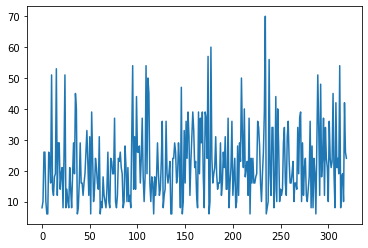

In [17]:
plt.plot((fail+success).reshape(-1))

In [ ]:
%%time

#thompson Sampling using Gaussian distribution:

T = 7000
W = model.layers[-1].get_weights()
n = np.zeros((64,5))
mu = np.zeros_like(n)
threshold = 0.005
norm_const=0.03
for i in range(1, T):
    
    #select random train data for comparison
    data = Select_Random_Data(train_data)
    
    #selecting index exploration/exploitation
    if np.where(n==0)[0].size == 0 and np.where(n==0)[1].size == 0:
        #np.save("check.npy", {"mu":mu, "n":n})
        index = TS_Normal(mu, n)
        ind_max =  np.array(np.unravel_index(index, n.shape))
        row = ind_max[0]
        col = ind_max[1]
    else:
        row = np.where(n==0)[0][0]
        col = np.where(n==0)[1][0]
    
    print("index:", i, row, col)
    
    #evaluating main model
    loss_base = model.evaluate(data, verbose=0)[0]

    #setting selected node to zero and evaluating again
    W_ = np.copy(W)
    W_[0][row, col] = 0
    model.layers[-1].set_weights(W_)
    loss = model.evaluate(data, verbose=0)[0]

    #calculating delta and reward
    delta = loss_base - loss
    reward = max(0, threshold + delta)/norm_const
    if reward >=1:
        reward = 0.99
    print("reward:", reward)
    
    #updating number of visiting the node and the average reward
    n[row, col] = n[row, col]+1
    mu[row, col] = ((n[row, col]-1)/n[row, col])*mu[row, col] + (1/n[row, col])*reward
    
    
    #initializing the layer to the original trained weights for next round
    model.layers[-1].set_weights(W)
    
    
print(n) 

index: 1 0 0
reward: 0.3271879900579948
index: 2 0 1
reward: 0.0
index: 3 0 2
reward: 0.30755674347664824
index: 4 0 3
reward: 0.0
index: 5 0 4
reward: 0.1361868881774122
index: 6 1 0
reward: 0.0
index: 7 1 1
reward: 0.638766945869279
index: 8 1 2
reward: 0.0
index: 9 1 3
reward: 0.0
index: 10 1 4
reward: 0.17203960971421808
index: 11 2 0
reward: 0.0
index: 12 2 1
reward: 0.17833244613936422
index: 13 2 2
reward: 0.8646858258128807
index: 14 2 3
reward: 0.525989939756694
index: 15 2 4
reward: 0.12616325680725538
index: 16 3 0
reward: 0.48238327549468496
index: 17 3 1
reward: 0.0
index: 18 3 2
reward: 0.47949221974598416
index: 19 3 3
reward: 0.5421370630186619
index: 20 3 4
reward: 0.035194973504519875
index: 21 4 0
reward: 0.09075876531258312
index: 22 4 1
reward: 0.16146908779453606
index: 23 4 2
reward: 0.0
index: 24 4 3
reward: 0.0
index: 25 4 4
reward: 0.0
index: 26 5 0
reward: 0.2249219727586653
index: 27 5 1
reward: 0.34906920701173866
index: 28 5 2
reward: 0.8241749573030712
in

In [ ]:
dic = {"n": n, "mu": mu}
np.save("result_weights_TS_Normal.npy", dic)

In [35]:
#Thompson Sampling using Beta priors:

T = 7000
W = model.layers[-1].get_weights()
success = np.zeros((64,5))
fail = np.zeros_like(success)
n = np.zeros_like(success)
threshold = 0.005
norm_const=0.03


for i in range(1, T):
    #select random train data for comparison
    data = Select_Random_Data(train_data)
    
    
    #selecting index exploration/exploitation
    if np.where(n==0)[0].size == 0 and np.where(n==0)[1].size == 0:
        
        index = TS_Beta(success, fail)
        ind_max =  np.array(np.unravel_index(index, success.shape))
        row = ind_max[0]
        col = ind_max[1]
        
    else:
        row = np.where(n==0)[0][0]
        col = np.where(n==0)[1][0]
        
    

    print("iteration:", i, "  index:", row, col)
    
    #evaluating main model
    loss_base = model.evaluate(data, verbose=0)[0]

    
    #setting selected node to zero and evaluating again
    W_ = np.copy(W)
    W_[0][row, col] = 0
    model.layers[-1].set_weights(W_)
    loss = model.evaluate(data, verbose=0)[0]
    
    #calculating delta and reward
    delta = loss_base - loss
    reward = max(0, threshold + delta)/norm_const
    
    #updating number of successes and fails 
    #the threshold for quantization is set to 0.5
    
    if reward >= 0.5:
        success[row, col] += 1
        print("successful")
    else:
        fail[row, col] += 1
        print("failed")
    
    n[row, col] =+ 1
    
    

    #initializing the layer to the original trained weights for next round
    model.layers[-1].set_weights(W)
    
    
    

check
iteration: 1   index: 0 0
failed
check
iteration: 2   index: 0 1
successful
check
iteration: 3   index: 0 2
failed
check
iteration: 4   index: 0 3
failed
check
iteration: 5   index: 0 4
failed
check
iteration: 6   index: 1 0
failed
check
iteration: 7   index: 1 1
successful
check
iteration: 8   index: 1 2
successful
check
iteration: 9   index: 1 3
successful
check
iteration: 10   index: 1 4
successful
check
iteration: 11   index: 2 0
failed
check
iteration: 12   index: 2 1
failed
check
iteration: 13   index: 2 2
failed
check
iteration: 14   index: 2 3
failed
check
iteration: 15   index: 2 4
successful
check
iteration: 16   index: 3 0
failed
check
iteration: 17   index: 3 1
successful
check
iteration: 18   index: 3 2
successful
check
iteration: 19   index: 3 3
failed
check
iteration: 20   index: 3 4
failed
check
iteration: 21   index: 4 0
failed
check
iteration: 22   index: 4 1
successful
check
iteration: 23   index: 4 2
failed
check
iteration: 24   index: 4 3
failed
check
iterati

failed
check
iteration: 194   index: 38 3
failed
check
iteration: 195   index: 38 4
failed
check
iteration: 196   index: 39 0
successful
check
iteration: 197   index: 39 1
failed
check
iteration: 198   index: 39 2
successful
check
iteration: 199   index: 39 3
successful
check
iteration: 200   index: 39 4
failed
check
iteration: 201   index: 40 0
failed
check
iteration: 202   index: 40 1
successful
check
iteration: 203   index: 40 2
successful
check
iteration: 204   index: 40 3
failed
check
iteration: 205   index: 40 4
failed
check
iteration: 206   index: 41 0
successful
check
iteration: 207   index: 41 1
successful
check
iteration: 208   index: 41 2
successful
check
iteration: 209   index: 41 3
successful
check
iteration: 210   index: 41 4
failed
check
iteration: 211   index: 42 0
successful
check
iteration: 212   index: 42 1
failed
check
iteration: 213   index: 42 2
failed
check
iteration: 214   index: 42 3
failed
check
iteration: 215   index: 42 4
failed
check
iteration: 216   index:

failed
iteration: 393   index: 33 4
failed
iteration: 394   index: 12 4
failed
iteration: 395   index: 51 3
failed
iteration: 396   index: 60 4
failed
iteration: 397   index: 1 1
failed
iteration: 398   index: 41 2
successful
iteration: 399   index: 10 0
successful
iteration: 400   index: 32 1
successful
iteration: 401   index: 25 2
failed
iteration: 402   index: 33 3
successful
iteration: 403   index: 34 0
failed
iteration: 404   index: 57 1
successful
iteration: 405   index: 39 2
failed
iteration: 406   index: 54 1
failed
iteration: 407   index: 57 1
successful
iteration: 408   index: 43 1
successful
iteration: 409   index: 32 1
failed
iteration: 410   index: 53 2
failed
iteration: 411   index: 18 3
successful
iteration: 412   index: 41 2
successful
iteration: 413   index: 20 0
successful
iteration: 414   index: 29 0
failed
iteration: 415   index: 12 3
failed
iteration: 416   index: 57 1
successful
iteration: 417   index: 10 0
failed
iteration: 418   index: 18 3
failed
iteration: 419

successful
iteration: 612   index: 33 3
successful
iteration: 613   index: 33 2
failed
iteration: 614   index: 13 4
successful
iteration: 615   index: 42 0
failed
iteration: 616   index: 8 0
successful
iteration: 617   index: 39 0
failed
iteration: 618   index: 51 1
failed
iteration: 619   index: 57 4
successful
iteration: 620   index: 49 3
failed
iteration: 621   index: 37 3
successful
iteration: 622   index: 56 3
successful
iteration: 623   index: 47 4
failed
iteration: 624   index: 34 1
successful
iteration: 625   index: 57 3
successful
iteration: 626   index: 8 0
failed
iteration: 627   index: 40 2
successful
iteration: 628   index: 49 4
failed
iteration: 629   index: 34 1
failed
iteration: 630   index: 6 2
failed
iteration: 631   index: 45 1
successful
iteration: 632   index: 57 4
failed
iteration: 633   index: 50 3
failed
iteration: 634   index: 25 3
successful
iteration: 635   index: 58 3
failed
iteration: 636   index: 23 2
failed
iteration: 637   index: 46 0
failed
iteration: 6

failed
iteration: 832   index: 55 2
failed
iteration: 833   index: 62 2
failed
iteration: 834   index: 12 2
failed
iteration: 835   index: 5 4
failed
iteration: 836   index: 56 0
successful
iteration: 837   index: 32 3
failed
iteration: 838   index: 33 3
failed
iteration: 839   index: 19 0
failed
iteration: 840   index: 41 1
failed
iteration: 841   index: 55 1
successful
iteration: 842   index: 29 3
failed
iteration: 843   index: 22 1
successful
iteration: 844   index: 1 1
successful
iteration: 845   index: 55 1
failed
iteration: 846   index: 57 0
successful
iteration: 847   index: 45 1
failed
iteration: 848   index: 16 3
failed
iteration: 849   index: 40 2
failed
iteration: 850   index: 11 4
successful
iteration: 851   index: 45 4
failed
iteration: 852   index: 55 1
failed
iteration: 853   index: 29 4
failed
iteration: 854   index: 15 3
successful
iteration: 855   index: 33 4
failed
iteration: 856   index: 46 1
failed
iteration: 857   index: 22 4
failed
iteration: 858   index: 41 2
fa

failed
iteration: 1050   index: 17 3
successful
iteration: 1051   index: 39 3
failed
iteration: 1052   index: 48 0
failed
iteration: 1053   index: 56 0
successful
iteration: 1054   index: 22 3
successful
iteration: 1055   index: 29 1
failed
iteration: 1056   index: 39 3
failed
iteration: 1057   index: 52 2
failed
iteration: 1058   index: 24 4
failed
iteration: 1059   index: 7 4
failed
iteration: 1060   index: 24 2
failed
iteration: 1061   index: 3 4
failed
iteration: 1062   index: 41 1
successful
iteration: 1063   index: 46 1
successful
iteration: 1064   index: 5 1
successful
iteration: 1065   index: 6 0
successful
iteration: 1066   index: 43 1
successful
iteration: 1067   index: 56 0
failed
iteration: 1068   index: 18 1
failed
iteration: 1069   index: 12 0
successful
iteration: 1070   index: 23 4
successful
iteration: 1071   index: 13 2
failed
iteration: 1072   index: 35 3
failed
iteration: 1073   index: 9 4
failed
iteration: 1074   index: 43 1
failed
iteration: 1075   index: 23 4
fai

failed
iteration: 1265   index: 44 2
successful
iteration: 1266   index: 30 1
failed
iteration: 1267   index: 40 4
failed
iteration: 1268   index: 44 1
successful
iteration: 1269   index: 61 3
failed
iteration: 1270   index: 40 4
failed
iteration: 1271   index: 12 0
successful
iteration: 1272   index: 24 0
failed
iteration: 1273   index: 11 4
successful
iteration: 1274   index: 1 3
failed
iteration: 1275   index: 47 3
failed
iteration: 1276   index: 26 4
failed
iteration: 1277   index: 16 4
failed
iteration: 1278   index: 14 0
successful
iteration: 1279   index: 31 4
failed
iteration: 1280   index: 6 3
failed
iteration: 1281   index: 38 4
failed
iteration: 1282   index: 1 4
successful
iteration: 1283   index: 42 4
failed
iteration: 1284   index: 45 2
successful
iteration: 1285   index: 57 2
failed
iteration: 1286   index: 43 3
successful
iteration: 1287   index: 9 3
failed
iteration: 1288   index: 51 2
failed
iteration: 1289   index: 6 4
failed
iteration: 1290   index: 39 1
failed
iter

failed
iteration: 1477   index: 5 0
successful
iteration: 1478   index: 37 2
failed
iteration: 1479   index: 9 4
successful
iteration: 1480   index: 34 2
failed
iteration: 1481   index: 18 4
successful
iteration: 1482   index: 16 4
failed
iteration: 1483   index: 18 4
successful
iteration: 1484   index: 42 1
failed
iteration: 1485   index: 18 4
successful
iteration: 1486   index: 48 2
failed
iteration: 1487   index: 43 4
failed
iteration: 1488   index: 10 4
failed
iteration: 1489   index: 12 0
successful
iteration: 1490   index: 47 3
failed
iteration: 1491   index: 18 4
failed
iteration: 1492   index: 45 3
successful
iteration: 1493   index: 36 0
failed
iteration: 1494   index: 18 4
successful
iteration: 1495   index: 17 1
failed
iteration: 1496   index: 44 4
failed
iteration: 1497   index: 63 0
failed
iteration: 1498   index: 35 4
failed
iteration: 1499   index: 5 2
failed
iteration: 1500   index: 16 3
failed
iteration: 1501   index: 52 3
failed
iteration: 1502   index: 30 3
failed
it

failed
iteration: 1690   index: 41 1
failed
iteration: 1691   index: 25 3
failed
iteration: 1692   index: 44 0
failed
iteration: 1693   index: 27 2
successful
iteration: 1694   index: 59 4
failed
iteration: 1695   index: 49 4
failed
iteration: 1696   index: 6 2
failed
iteration: 1697   index: 19 1
successful
iteration: 1698   index: 6 0
failed
iteration: 1699   index: 28 1
successful
iteration: 1700   index: 45 2
failed
iteration: 1701   index: 15 3
successful
iteration: 1702   index: 38 2
successful
iteration: 1703   index: 60 0
successful
iteration: 1704   index: 47 4
successful
iteration: 1705   index: 19 1
successful
iteration: 1706   index: 0 3
failed
iteration: 1707   index: 51 0
failed
iteration: 1708   index: 18 3
successful
iteration: 1709   index: 58 0
failed
iteration: 1710   index: 27 2
failed
iteration: 1711   index: 62 3
successful
iteration: 1712   index: 45 0
failed
iteration: 1713   index: 53 4
successful
iteration: 1714   index: 15 1
successful
iteration: 1715   index

failed
iteration: 1903   index: 18 0
failed
iteration: 1904   index: 4 1
failed
iteration: 1905   index: 56 3
failed
iteration: 1906   index: 32 4
successful
iteration: 1907   index: 50 0
failed
iteration: 1908   index: 25 3
successful
iteration: 1909   index: 13 2
successful
iteration: 1910   index: 32 0
failed
iteration: 1911   index: 1 1
successful
iteration: 1912   index: 32 3
successful
iteration: 1913   index: 43 3
successful
iteration: 1914   index: 57 3
failed
iteration: 1915   index: 8 3
failed
iteration: 1916   index: 20 3
failed
iteration: 1917   index: 40 2
successful
iteration: 1918   index: 1 1
successful
iteration: 1919   index: 25 1
failed
iteration: 1920   index: 50 2
successful
iteration: 1921   index: 57 0
failed
iteration: 1922   index: 5 1
successful
iteration: 1923   index: 45 3
successful
iteration: 1924   index: 45 0
failed
iteration: 1925   index: 18 1
successful
iteration: 1926   index: 9 2
successful
iteration: 1927   index: 40 3
failed
iteration: 1928   inde

successful
iteration: 2116   index: 26 3
failed
iteration: 2117   index: 3 1
successful
iteration: 2118   index: 9 2
successful
iteration: 2119   index: 52 3
failed
iteration: 2120   index: 49 0
failed
iteration: 2121   index: 16 1
successful
iteration: 2122   index: 3 4
failed
iteration: 2123   index: 0 4
failed
iteration: 2124   index: 18 4
failed
iteration: 2125   index: 7 2
failed
iteration: 2126   index: 35 4
failed
iteration: 2127   index: 46 3
failed
iteration: 2128   index: 32 1
failed
iteration: 2129   index: 60 4
failed
iteration: 2130   index: 1 2
failed
iteration: 2131   index: 41 4
successful
iteration: 2132   index: 15 0
failed
iteration: 2133   index: 15 2
failed
iteration: 2134   index: 60 0
failed
iteration: 2135   index: 50 3
failed
iteration: 2136   index: 36 0
successful
iteration: 2137   index: 47 2
successful
iteration: 2138   index: 43 1
failed
iteration: 2139   index: 47 3
failed
iteration: 2140   index: 43 3
successful
iteration: 2141   index: 41 4
successful
i

failed
iteration: 2329   index: 41 4
successful
iteration: 2330   index: 36 0
successful
iteration: 2331   index: 60 2
successful
iteration: 2332   index: 60 2
successful
iteration: 2333   index: 30 0
failed
iteration: 2334   index: 38 2
failed
iteration: 2335   index: 10 2
failed
iteration: 2336   index: 20 2
successful
iteration: 2337   index: 20 2
successful
iteration: 2338   index: 50 0
successful
iteration: 2339   index: 30 0
failed
iteration: 2340   index: 11 2
failed
iteration: 2341   index: 16 1
failed
iteration: 2342   index: 20 2
failed
iteration: 2343   index: 22 0
successful
iteration: 2344   index: 21 2
failed
iteration: 2345   index: 46 4
failed
iteration: 2346   index: 32 4
failed
iteration: 2347   index: 15 1
failed
iteration: 2348   index: 36 0
successful
iteration: 2349   index: 43 0
failed
iteration: 2350   index: 43 3
failed
iteration: 2351   index: 30 0
failed
iteration: 2352   index: 22 0
successful
iteration: 2353   index: 14 1
failed
iteration: 2354   index: 6 3

successful
iteration: 2542   index: 19 1
failed
iteration: 2543   index: 59 4
failed
iteration: 2544   index: 18 3
failed
iteration: 2545   index: 28 4
successful
iteration: 2546   index: 45 2
failed
iteration: 2547   index: 13 2
failed
iteration: 2548   index: 19 1
failed
iteration: 2549   index: 51 2
successful
iteration: 2550   index: 8 3
failed
iteration: 2551   index: 28 2
successful
iteration: 2552   index: 49 4
successful
iteration: 2553   index: 33 0
failed
iteration: 2554   index: 41 2
failed
iteration: 2555   index: 51 2
successful
iteration: 2556   index: 41 1
failed
iteration: 2557   index: 47 3
failed
iteration: 2558   index: 51 2
failed
iteration: 2559   index: 51 2
failed
iteration: 2560   index: 21 3
failed
iteration: 2561   index: 60 0
failed
iteration: 2562   index: 9 1
successful
iteration: 2563   index: 24 4
failed
iteration: 2564   index: 49 4
successful
iteration: 2565   index: 11 1
failed
iteration: 2566   index: 58 0
failed
iteration: 2567   index: 60 1
successf

failed
iteration: 2756   index: 43 1
failed
iteration: 2757   index: 42 4
failed
iteration: 2758   index: 28 4
failed
iteration: 2759   index: 57 1
failed
iteration: 2760   index: 43 1
successful
iteration: 2761   index: 62 0
successful
iteration: 2762   index: 34 4
successful
iteration: 2763   index: 60 0
failed
iteration: 2764   index: 1 1
successful
iteration: 2765   index: 15 3
failed
iteration: 2766   index: 57 4
failed
iteration: 2767   index: 59 1
failed
iteration: 2768   index: 28 0
failed
iteration: 2769   index: 11 4
successful
iteration: 2770   index: 60 2
successful
iteration: 2771   index: 22 1
failed
iteration: 2772   index: 59 1
successful
iteration: 2773   index: 40 3
failed
iteration: 2774   index: 50 2
failed
iteration: 2775   index: 24 2
failed
iteration: 2776   index: 13 1
successful
iteration: 2777   index: 11 4
failed
iteration: 2778   index: 46 3
successful
iteration: 2779   index: 18 1
failed
iteration: 2780   index: 31 4
successful
iteration: 2781   index: 28 2

successful
iteration: 2969   index: 50 1
successful
iteration: 2970   index: 49 4
failed
iteration: 2971   index: 38 4
successful
iteration: 2972   index: 30 4
successful
iteration: 2973   index: 61 2
failed
iteration: 2974   index: 51 1
successful
iteration: 2975   index: 50 3
failed
iteration: 2976   index: 10 2
successful
iteration: 2977   index: 30 3
successful
iteration: 2978   index: 33 0
successful
iteration: 2979   index: 38 4
failed
iteration: 2980   index: 33 0
failed
iteration: 2981   index: 24 0
failed
iteration: 2982   index: 27 4
failed
iteration: 2983   index: 28 2
failed
iteration: 2984   index: 12 0
successful
iteration: 2985   index: 30 3
successful
iteration: 2986   index: 55 2
failed
iteration: 2987   index: 28 0
failed
iteration: 2988   index: 0 4
failed
iteration: 2989   index: 16 1
successful
iteration: 2990   index: 1 4
successful
iteration: 2991   index: 46 1
failed
iteration: 2992   index: 14 0
successful
iteration: 2993   index: 1 4
failed
iteration: 2994   i

failed
iteration: 3181   index: 57 2
failed
iteration: 3182   index: 62 0
successful
iteration: 3183   index: 33 4
successful
iteration: 3184   index: 38 0
successful
iteration: 3185   index: 34 4
failed
iteration: 3186   index: 6 0
failed
iteration: 3187   index: 22 1
failed
iteration: 3188   index: 55 2
failed
iteration: 3189   index: 48 0
failed
iteration: 3190   index: 17 3
failed
iteration: 3191   index: 30 3
successful
iteration: 3192   index: 51 1
failed
iteration: 3193   index: 52 4
failed
iteration: 3194   index: 56 0
failed
iteration: 3195   index: 41 4
failed
iteration: 3196   index: 31 1
failed
iteration: 3197   index: 16 2
failed
iteration: 3198   index: 63 0
successful
iteration: 3199   index: 60 2
failed
iteration: 3200   index: 9 3
successful
iteration: 3201   index: 6 1
failed
iteration: 3202   index: 52 1
failed
iteration: 3203   index: 27 4
successful
iteration: 3204   index: 30 4
successful
iteration: 3205   index: 30 3
failed
iteration: 3206   index: 25 3
failed
it

successful
iteration: 3394   index: 52 0
failed
iteration: 3395   index: 5 1
failed
iteration: 3396   index: 58 1
successful
iteration: 3397   index: 17 1
failed
iteration: 3398   index: 60 1
successful
iteration: 3399   index: 60 0
failed
iteration: 3400   index: 9 0
successful
iteration: 3401   index: 17 3
successful
iteration: 3402   index: 36 3
successful
iteration: 3403   index: 63 2
successful
iteration: 3404   index: 36 3
successful
iteration: 3405   index: 33 1
successful
iteration: 3406   index: 40 4
failed
iteration: 3407   index: 48 2
failed
iteration: 3408   index: 40 4
successful
iteration: 3409   index: 3 2
failed
iteration: 3410   index: 37 2
successful
iteration: 3411   index: 33 4
failed
iteration: 3412   index: 26 2
successful
iteration: 3413   index: 57 1
successful
iteration: 3414   index: 27 0
successful
iteration: 3415   index: 37 0
successful
iteration: 3416   index: 45 3
failed
iteration: 3417   index: 20 1
successful
iteration: 3418   index: 13 2
failed
iterati

failed
iteration: 3606   index: 20 4
failed
iteration: 3607   index: 27 4
successful
iteration: 3608   index: 25 2
successful
iteration: 3609   index: 48 3
failed
iteration: 3610   index: 42 0
failed
iteration: 3611   index: 13 2
failed
iteration: 3612   index: 24 0
successful
iteration: 3613   index: 30 0
successful
iteration: 3614   index: 43 0
failed
iteration: 3615   index: 41 4
successful
iteration: 3616   index: 15 1
failed
iteration: 3617   index: 51 2
failed
iteration: 3618   index: 57 1
successful
iteration: 3619   index: 33 0
failed
iteration: 3620   index: 59 4
failed
iteration: 3621   index: 5 2
successful
iteration: 3622   index: 45 1
failed
iteration: 3623   index: 42 0
failed
iteration: 3624   index: 13 2
successful
iteration: 3625   index: 49 1
failed
iteration: 3626   index: 27 2
failed
iteration: 3627   index: 54 1
failed
iteration: 3628   index: 4 4
failed
iteration: 3629   index: 42 1
successful
iteration: 3630   index: 16 0
failed
iteration: 3631   index: 15 1
succ

failed
iteration: 3819   index: 56 3
successful
iteration: 3820   index: 18 4
failed
iteration: 3821   index: 46 2
failed
iteration: 3822   index: 31 1
successful
iteration: 3823   index: 57 3
successful
iteration: 3824   index: 26 4
failed
iteration: 3825   index: 53 0
failed
iteration: 3826   index: 25 3
failed
iteration: 3827   index: 30 3
failed
iteration: 3828   index: 54 0
successful
iteration: 3829   index: 19 4
failed
iteration: 3830   index: 1 1
successful
iteration: 3831   index: 34 4
failed
iteration: 3832   index: 53 4
failed
iteration: 3833   index: 53 0
failed
iteration: 3834   index: 39 0
failed
iteration: 3835   index: 7 3
failed
iteration: 3836   index: 32 3
failed
iteration: 3837   index: 44 0
failed
iteration: 3838   index: 19 3
failed
iteration: 3839   index: 62 1
successful
iteration: 3840   index: 0 0
successful
iteration: 3841   index: 53 0
failed
iteration: 3842   index: 59 1
failed
iteration: 3843   index: 40 1
failed
iteration: 3844   index: 29 2
failed
iterat

failed
iteration: 4033   index: 24 0
failed
iteration: 4034   index: 59 4
failed
iteration: 4035   index: 0 0
failed
iteration: 4036   index: 31 3
successful
iteration: 4037   index: 41 2
failed
iteration: 4038   index: 52 0
failed
iteration: 4039   index: 12 4
failed
iteration: 4040   index: 5 0
failed
iteration: 4041   index: 61 3
failed
iteration: 4042   index: 20 1
failed
iteration: 4043   index: 52 4
successful
iteration: 4044   index: 0 0
successful
iteration: 4045   index: 45 4
successful
iteration: 4046   index: 16 1
failed
iteration: 4047   index: 36 3
successful
iteration: 4048   index: 20 1
failed
iteration: 4049   index: 57 1
failed
iteration: 4050   index: 18 1
failed
iteration: 4051   index: 0 0
failed
iteration: 4052   index: 10 2
failed
iteration: 4053   index: 4 1
successful
iteration: 4054   index: 14 4
failed
iteration: 4055   index: 40 2
failed
iteration: 4056   index: 61 0
failed
iteration: 4057   index: 29 2
failed
iteration: 4058   index: 36 4
successful
iteratio

successful
iteration: 4245   index: 36 3
failed
iteration: 4246   index: 12 4
failed
iteration: 4247   index: 55 2
successful
iteration: 4248   index: 56 2
failed
iteration: 4249   index: 40 1
failed
iteration: 4250   index: 47 2
failed
iteration: 4251   index: 2 1
failed
iteration: 4252   index: 58 0
failed
iteration: 4253   index: 38 4
successful
iteration: 4254   index: 40 4
failed
iteration: 4255   index: 0 0
failed
iteration: 4256   index: 32 1
failed
iteration: 4257   index: 54 0
failed
iteration: 4258   index: 11 2
failed
iteration: 4259   index: 18 0
failed
iteration: 4260   index: 7 0
failed
iteration: 4261   index: 20 1
failed
iteration: 4262   index: 9 2
failed
iteration: 4263   index: 50 4
failed
iteration: 4264   index: 34 1
failed
iteration: 4265   index: 10 1
successful
iteration: 4266   index: 30 0
successful
iteration: 4267   index: 35 2
successful
iteration: 4268   index: 48 1
failed
iteration: 4269   index: 3 4
failed
iteration: 4270   index: 9 2
failed
iteration: 42

successful
iteration: 4460   index: 43 0
failed
iteration: 4461   index: 9 4
successful
iteration: 4462   index: 49 2
successful
iteration: 4463   index: 61 2
failed
iteration: 4464   index: 40 2
failed
iteration: 4465   index: 52 4
successful
iteration: 4466   index: 55 2
failed
iteration: 4467   index: 55 1
failed
iteration: 4468   index: 57 1
failed
iteration: 4469   index: 10 3
successful
iteration: 4470   index: 41 3
successful
iteration: 4471   index: 46 3
successful
iteration: 4472   index: 31 2
failed
iteration: 4473   index: 1 1
failed
iteration: 4474   index: 51 1
successful
iteration: 4475   index: 18 3
successful
iteration: 4476   index: 55 3
failed
iteration: 4477   index: 52 4
failed
iteration: 4478   index: 18 4
failed
iteration: 4479   index: 9 2
failed
iteration: 4480   index: 37 2
failed
iteration: 4481   index: 34 2
successful
iteration: 4482   index: 30 0
failed
iteration: 4483   index: 42 2
failed
iteration: 4484   index: 13 4
successful
iteration: 4485   index: 41

failed
iteration: 4673   index: 41 1
successful
iteration: 4674   index: 18 3
failed
iteration: 4675   index: 49 4
failed
iteration: 4676   index: 37 2
failed
iteration: 4677   index: 59 3
successful
iteration: 4678   index: 41 3
failed
iteration: 4679   index: 2 1
successful
iteration: 4680   index: 46 3
failed
iteration: 4681   index: 38 2
failed
iteration: 4682   index: 11 3
failed
iteration: 4683   index: 28 4
failed
iteration: 4684   index: 41 3
failed
iteration: 4685   index: 30 4
successful
iteration: 4686   index: 20 4
failed
iteration: 4687   index: 10 3
failed
iteration: 4688   index: 14 3
failed
iteration: 4689   index: 27 4
successful
iteration: 4690   index: 36 1
successful
iteration: 4691   index: 0 3
successful
iteration: 4692   index: 29 3
failed
iteration: 4693   index: 13 4
failed
iteration: 4694   index: 41 2
successful
iteration: 4695   index: 60 1
successful
iteration: 4696   index: 48 4
successful
iteration: 4697   index: 63 3
failed
iteration: 4698   index: 62 3


failed
iteration: 4886   index: 14 0
successful
iteration: 4887   index: 13 4
successful
iteration: 4888   index: 10 2
failed
iteration: 4889   index: 21 0
failed
iteration: 4890   index: 14 0
failed
iteration: 4891   index: 9 3
failed
iteration: 4892   index: 6 2
failed
iteration: 4893   index: 34 2
failed
iteration: 4894   index: 37 2
failed
iteration: 4895   index: 35 3
successful
iteration: 4896   index: 5 3
successful
iteration: 4897   index: 45 4
failed
iteration: 4898   index: 34 2
successful
iteration: 4899   index: 6 2
successful
iteration: 4900   index: 0 4
successful
iteration: 4901   index: 46 3
successful
iteration: 4902   index: 46 1
failed
iteration: 4903   index: 54 0
successful
iteration: 4904   index: 4 2
failed
iteration: 4905   index: 42 2
failed
iteration: 4906   index: 6 3
successful
iteration: 4907   index: 11 4
failed
iteration: 4908   index: 12 0
failed
iteration: 4909   index: 8 3
successful
iteration: 4910   index: 26 3
failed
iteration: 4911   index: 49 4
su

failed
iteration: 5098   index: 63 0
successful
iteration: 5099   index: 21 1
failed
iteration: 5100   index: 34 4
successful
iteration: 5101   index: 57 2
failed
iteration: 5102   index: 41 4
successful
iteration: 5103   index: 59 2
successful
iteration: 5104   index: 57 1
successful
iteration: 5105   index: 20 1
successful
iteration: 5106   index: 35 2
successful
iteration: 5107   index: 57 3
successful
iteration: 5108   index: 7 3
failed
iteration: 5109   index: 34 2
successful
iteration: 5110   index: 20 1
failed
iteration: 5111   index: 25 4
failed
iteration: 5112   index: 31 1
failed
iteration: 5113   index: 28 1
successful
iteration: 5114   index: 49 3
failed
iteration: 5115   index: 6 2
failed
iteration: 5116   index: 12 0
successful
iteration: 5117   index: 30 0
successful
iteration: 5118   index: 8 3
successful
iteration: 5119   index: 57 3
successful
iteration: 5120   index: 48 3
successful
iteration: 5121   index: 20 1
failed
iteration: 5122   index: 18 1
failed
iteration: 

successful
iteration: 5311   index: 28 1
failed
iteration: 5312   index: 6 4
successful
iteration: 5313   index: 38 4
failed
iteration: 5314   index: 59 2
failed
iteration: 5315   index: 36 4
successful
iteration: 5316   index: 21 2
failed
iteration: 5317   index: 15 3
failed
iteration: 5318   index: 12 3
successful
iteration: 5319   index: 44 4
successful
iteration: 5320   index: 45 0
successful
iteration: 5321   index: 6 2
failed
iteration: 5322   index: 57 1
failed
iteration: 5323   index: 44 4
successful
iteration: 5324   index: 31 1
failed
iteration: 5325   index: 47 2
successful
iteration: 5326   index: 51 2
successful
iteration: 5327   index: 14 4
successful
iteration: 5328   index: 52 0
failed
iteration: 5329   index: 51 1
successful
iteration: 5330   index: 30 0
successful
iteration: 5331   index: 24 0
failed
iteration: 5332   index: 5 3
failed
iteration: 5333   index: 26 1
failed
iteration: 5334   index: 63 1
successful
iteration: 5335   index: 37 1
successful
iteration: 5336

failed
iteration: 5525   index: 1 0
successful
iteration: 5526   index: 18 3
failed
iteration: 5527   index: 34 2
successful
iteration: 5528   index: 44 0
failed
iteration: 5529   index: 47 4
failed
iteration: 5530   index: 58 0
successful
iteration: 5531   index: 50 4
failed
iteration: 5532   index: 7 0
failed
iteration: 5533   index: 10 2
failed
iteration: 5534   index: 0 0
successful
iteration: 5535   index: 58 0
successful
iteration: 5536   index: 45 0
failed
iteration: 5537   index: 20 1
successful
iteration: 5538   index: 21 1
failed
iteration: 5539   index: 34 2
failed
iteration: 5540   index: 10 0
successful
iteration: 5541   index: 22 0
failed
iteration: 5542   index: 31 1
successful
iteration: 5543   index: 41 4
successful
iteration: 5544   index: 20 3
failed
iteration: 5545   index: 48 2
successful
iteration: 5546   index: 20 1
successful
iteration: 5547   index: 0 0
successful
iteration: 5548   index: 18 4
failed
iteration: 5549   index: 1 0
failed
iteration: 5550   index: 

failed
iteration: 5738   index: 0 4
failed
iteration: 5739   index: 49 2
successful
iteration: 5740   index: 4 1
failed
iteration: 5741   index: 6 2
failed
iteration: 5742   index: 12 3
successful
iteration: 5743   index: 58 0
successful
iteration: 5744   index: 0 4
failed
iteration: 5745   index: 41 1
successful
iteration: 5746   index: 52 4
successful
iteration: 5747   index: 56 2
failed
iteration: 5748   index: 0 4
successful
iteration: 5749   index: 59 4
failed
iteration: 5750   index: 40 3
failed
iteration: 5751   index: 45 3
failed
iteration: 5752   index: 36 3
failed
iteration: 5753   index: 62 1
failed
iteration: 5754   index: 54 0
failed
iteration: 5755   index: 9 2
successful
iteration: 5756   index: 58 0
failed
iteration: 5757   index: 37 2
failed
iteration: 5758   index: 4 4
failed
iteration: 5759   index: 51 3
successful
iteration: 5760   index: 0 0
successful
iteration: 5761   index: 49 0
successful
iteration: 5762   index: 10 0
failed
iteration: 5763   index: 25 3
failed

failed
iteration: 5951   index: 55 2
failed
iteration: 5952   index: 41 1
successful
iteration: 5953   index: 35 2
successful
iteration: 5954   index: 12 3
successful
iteration: 5955   index: 57 4
failed
iteration: 5956   index: 15 1
successful
iteration: 5957   index: 34 2
successful
iteration: 5958   index: 10 0
successful
iteration: 5959   index: 7 4
successful
iteration: 5960   index: 53 1
failed
iteration: 5961   index: 44 4
failed
iteration: 5962   index: 62 0
successful
iteration: 5963   index: 43 2
failed
iteration: 5964   index: 32 3
successful
iteration: 5965   index: 29 2
successful
iteration: 5966   index: 11 2
failed
iteration: 5967   index: 2 2
failed
iteration: 5968   index: 15 0
failed
iteration: 5969   index: 38 4
failed
iteration: 5970   index: 47 2
successful
iteration: 5971   index: 52 4
failed
iteration: 5972   index: 19 1
successful
iteration: 5973   index: 57 3
failed
iteration: 5974   index: 23 0
failed
iteration: 5975   index: 36 3
failed
iteration: 5976   inde

failed
iteration: 6165   index: 0 0
successful
iteration: 6166   index: 21 3
failed
iteration: 6167   index: 36 3
failed
iteration: 6168   index: 22 1
failed
iteration: 6169   index: 34 0
failed
iteration: 6170   index: 37 0
failed
iteration: 6171   index: 56 3
failed
iteration: 6172   index: 10 0
failed
iteration: 6173   index: 61 3
successful
iteration: 6174   index: 39 4
failed
iteration: 6175   index: 39 4
failed
iteration: 6176   index: 52 2
failed
iteration: 6177   index: 5 1
successful
iteration: 6178   index: 63 1
successful
iteration: 6179   index: 52 0
failed
iteration: 6180   index: 18 3
failed
iteration: 6181   index: 28 2
failed
iteration: 6182   index: 18 2
successful
iteration: 6183   index: 49 4
successful
iteration: 6184   index: 41 4
successful
iteration: 6185   index: 21 2
failed
iteration: 6186   index: 24 2
failed
iteration: 6187   index: 58 3
failed
iteration: 6188   index: 1 1
successful
iteration: 6189   index: 61 3
failed
iteration: 6190   index: 12 3
failed
it

successful
iteration: 6378   index: 12 2
successful
iteration: 6379   index: 30 0
successful
iteration: 6380   index: 18 3
failed
iteration: 6381   index: 13 0
successful
iteration: 6382   index: 18 4
successful
iteration: 6383   index: 52 1
successful
iteration: 6384   index: 52 3
failed
iteration: 6385   index: 49 2
successful
iteration: 6386   index: 10 3
successful
iteration: 6387   index: 60 1
failed
iteration: 6388   index: 13 2
failed
iteration: 6389   index: 4 4
failed
iteration: 6390   index: 22 3
failed
iteration: 6391   index: 12 2
failed
iteration: 6392   index: 59 3
successful
iteration: 6393   index: 10 0
failed
iteration: 6394   index: 48 2
successful
iteration: 6395   index: 35 1
successful
iteration: 6396   index: 47 3
failed
iteration: 6397   index: 60 0
successful
iteration: 6398   index: 28 1
failed
iteration: 6399   index: 29 2
successful
iteration: 6400   index: 59 2
failed
iteration: 6401   index: 35 3
failed
iteration: 6402   index: 34 3
failed
iteration: 6403  

failed
iteration: 6590   index: 59 1
failed
iteration: 6591   index: 49 2
failed
iteration: 6592   index: 63 1
successful
iteration: 6593   index: 30 4
successful
iteration: 6594   index: 57 1
successful
iteration: 6595   index: 18 4
successful
iteration: 6596   index: 59 3
failed
iteration: 6597   index: 21 2
successful
iteration: 6598   index: 60 2
failed
iteration: 6599   index: 18 2
failed
iteration: 6600   index: 14 2
failed
iteration: 6601   index: 58 0
successful
iteration: 6602   index: 50 1
failed
iteration: 6603   index: 57 1
successful
iteration: 6604   index: 37 3
failed
iteration: 6605   index: 17 2
failed
iteration: 6606   index: 20 2
successful
iteration: 6607   index: 2 4
successful
iteration: 6608   index: 18 2
successful
iteration: 6609   index: 59 4
successful
iteration: 6610   index: 33 2
failed
iteration: 6611   index: 50 1
failed
iteration: 6612   index: 62 4
failed
iteration: 6613   index: 15 0
failed
iteration: 6614   index: 63 3
failed
iteration: 6615   index: 

successful
iteration: 6804   index: 28 2
failed
iteration: 6805   index: 30 2
failed
iteration: 6806   index: 29 0
successful
iteration: 6807   index: 2 4
failed
iteration: 6808   index: 25 3
successful
iteration: 6809   index: 5 2
failed
iteration: 6810   index: 60 2
failed
iteration: 6811   index: 34 4
failed
iteration: 6812   index: 63 3
successful
iteration: 6813   index: 56 0
successful
iteration: 6814   index: 52 1
failed
iteration: 6815   index: 1 0
failed
iteration: 6816   index: 49 3
failed
iteration: 6817   index: 0 3
successful
iteration: 6818   index: 30 0
successful
iteration: 6819   index: 53 2
failed
iteration: 6820   index: 29 1
failed
iteration: 6821   index: 31 1
successful
iteration: 6822   index: 27 4
successful
iteration: 6823   index: 53 0
successful
iteration: 6824   index: 49 4
failed
iteration: 6825   index: 31 2
successful
iteration: 6826   index: 36 0
failed
iteration: 6827   index: 32 1
failed
iteration: 6828   index: 58 4
successful
iteration: 6829   index:

In [36]:
dic = {"n": n, "s": success, "f": fail}
np.save("result_weights_TS_Beta.npy", dic)

In [25]:
%%time

#KL_UCB:
T = 7000
W = model.layers[-1].get_weights()
n = np.zeros((64,5))
mu = np.zeros_like(n)
threshold = 0.005
norm_const=0.03
for i in range(1, T):
    #select random train data for comparison
    data = select_random_data(train_data)
    
    #selecting index exploration/exploitation
    if np.where(n==0)[0].size == 0 and np.where(n==0)[1].size == 0:
        #np.save("check.npy", {"mu":mu, "n":n})
        index = KL_UCB(mu, n, i)
        ind_max =  np.array(np.unravel_index(index, n.shape))
        row = ind_max[0]
        col = ind_max[1]
    else:
        row = np.where(n==0)[0][0]
        col = np.where(n==0)[1][0]
    
    print("index:", i, row, col)
    
    #evaluating main model
    loss_base = model.evaluate(data, verbose=0)[0]

    #setting selected node to zero and evaluating again
    W_ = np.copy(W)
    W_[0][row, col] = 0
    model.layers[-1].set_weights(W_)
    loss = model.evaluate(data, verbose=0)[0]

    #calculating delta and reward
    delta = loss_base - loss
    reward = max(0, threshold + delta)/norm_const
    if reward >=1:
        reward = 0.99
    print("reward:", reward)
    
    #updating number of visiting the node and the average reward
    n[row, col] = n[row, col]+1
    mu[row, col] = ((n[row, col]-1)/n[row, col])*mu[row, col] + (1/n[row, col])*reward
    #initializing the layer to the original trained weights for next round
    model.layers[-1].set_weights(W)
    
    
print(n) 

index: 1 0 0
reward: 0.0
index: 2 0 1
reward: 0.0
index: 3 0 2
reward: 0.0
index: 4 0 3
reward: 0.3041513853821684
index: 5 0 4
reward: 0.0
index: 6 1 0
reward: 0.7724100621971522
index: 7 1 1
reward: 0.0
index: 8 1 2
reward: 0.22440686432396703
index: 9 1 3
reward: 0.27686124769140386
index: 10 1 4
reward: 0.28821959094623045
index: 11 2 0
reward: 0.0
index: 12 2 1
reward: 0.17414042013762032
index: 13 2 2
reward: 0.99
index: 14 2 3
reward: 0.29554033369409877
index: 15 2 4
reward: 0.2715788827098598
index: 16 3 0
reward: 0.0
index: 17 3 1
reward: 0.0
index: 18 3 2
reward: 0.7268702015762314
index: 19 3 3
reward: 0.0
index: 20 3 4
reward: 0.0
index: 21 4 0
reward: 0.0
index: 22 4 1
reward: 0.99
index: 23 4 2
reward: 0.0
index: 24 4 3
reward: 0.2578640586292571
index: 25 4 4
reward: 0.0
index: 26 5 0
reward: 0.0
index: 27 5 1
reward: 0.99
index: 28 5 2
reward: 0.7596335929616578
index: 29 5 3
reward: 0.0
index: 30 5 4
reward: 0.28903124726535506
index: 31 6 0
reward: 0.4338058205476187

reward: 0.3691315963154676
index: 267 53 1
reward: 0.99
index: 268 53 2
reward: 0.8032585117551967
index: 269 53 3
reward: 0.1379116546540029
index: 270 53 4
reward: 0.0
index: 271 54 0
reward: 0.0
index: 272 54 1
reward: 0.0
index: 273 54 2
reward: 0.99
index: 274 54 3
reward: 0.99
index: 275 54 4
reward: 0.9585974784124521
index: 276 55 0
reward: 0.99
index: 277 55 1
reward: 0.37786079588389226
index: 278 55 2
reward: 0.8811259534623879
index: 279 55 3
reward: 0.06685934180305668
index: 280 55 4
reward: 0.99
index: 281 56 0
reward: 0.009370865329856912
index: 282 56 1
reward: 0.99
index: 283 56 2
reward: 0.11100323238070924
index: 284 56 3
reward: 0.0
index: 285 56 4
reward: 0.0
index: 286 57 0
reward: 0.0
index: 287 57 1
reward: 0.99
index: 288 57 2
reward: 0.5342475081247002
index: 289 57 3
reward: 0.0
index: 290 57 4
reward: 0.99
index: 291 58 0
reward: 0.5827429729794774
index: 292 58 1
reward: 0.0
index: 293 58 2
reward: 0.99
index: 294 58 3
reward: 0.0
index: 295 58 4
reward: 0

/home/fe/khodabakhshandeh/anaconda3/envs/main-env/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in double_scalars


reward: 0.0019235251441835205
index: 322 55 3
reward: 0.99
index: 323 11 2
reward: 0.9948881826703541
index: 324 53 3
reward: 0.0
index: 325 14 4
reward: 0.0
index: 326 41 0
reward: 0.4959362442531219
index: 327 10 4
reward: 0.11190853232429691
index: 328 24 2
reward: 0.4525251407471878
index: 329 56 0
reward: 0.0
index: 330 51 1
reward: 0.49491374076358424
index: 331 5 4
reward: 0.5374218812064493
index: 332 59 4
reward: 0.0
index: 333 6 2
reward: 0.08641298611958823
index: 334 49 4
reward: 0.15656779493604284
index: 335 4 3
reward: 0.25039933787452195
index: 336 60 4
reward: 0.6927046870428443
index: 337 1 4
reward: 0.483496064231507
index: 338 60 0
reward: 0.0
index: 339 56 2
reward: 0.2775358661772734
index: 340 53 0
reward: 0.99
index: 341 2 1
reward: 0.10662259374345863
index: 342 17 2
reward: 0.621571122653904
index: 343 1 3
reward: 0.10967361359368956
index: 344 1 2
reward: 0.0
index: 345 16 1
reward: 0.8379576773870541
index: 346 63 2
reward: 0.2732590247714327
index: 347 63 3

reward: 0.9784942846449558
index: 545 2 1
reward: 0.0
index: 546 46 0
reward: 0.0
index: 547 57 2
reward: 0.0
index: 548 58 0
reward: 0.99
index: 549 41 0
reward: 0.3822564208318316
index: 550 63 3
reward: 0.23627221395099046
index: 551 9 0
reward: 0.45162589587862667
index: 552 56 0
reward: 0.254783600095724
index: 553 6 2
reward: 0.99
index: 554 59 4
reward: 0.0
index: 555 49 4
reward: 0.0
index: 556 38 4
reward: 0.99
index: 557 14 4
reward: 0.0
index: 558 61 1
reward: 0.44604961645035013
index: 559 29 3
reward: 0.25658700012025254
index: 560 29 3
reward: 0.5478151147327672
index: 561 29 3
reward: 0.17115926742553564
index: 562 12 1
reward: 0.0
index: 563 5 4
reward: 0.0
index: 564 29 3
reward: 0.5249876900324745
index: 565 55 1
reward: 0.0
index: 566 63 2
reward: 0.0
index: 567 2 3
reward: 0.17473514874776205
index: 568 10 4
reward: 0.0
index: 569 61 2
reward: 0.0
index: 570 37 1
reward: 0.4006815883848398
index: 571 49 1
reward: 0.1205891824903936
index: 572 33 4
reward: 0.0
index:

reward: 0.0
index: 769 61 4
reward: 0.0
index: 770 51 1
reward: 0.22121090548378913
index: 771 24 2
reward: 0.1485487752490613
index: 772 62 4
reward: 0.99
index: 773 46 2
reward: 0.14907103493099932
index: 774 1 4
reward: 0.5175124823101006
index: 775 10 4
reward: 0.0
index: 776 49 2
reward: 0.2478928868732761
index: 777 63 2
reward: 0.9540124904541739
index: 778 50 3
reward: 0.0
index: 779 63 3
reward: 0.4701972461882086
index: 780 49 4
reward: 0.009969376382375536
index: 781 14 4
reward: 0.0
index: 782 9 0
reward: 0.06675198721507444
index: 783 53 0
reward: 0.2939486295457889
index: 784 41 0
reward: 0.0
index: 785 33 4
reward: 0.1894117328855692
index: 786 49 1
reward: 0.0
index: 787 61 2
reward: 0.2071906725565637
index: 788 1 2
reward: 0.3538875712288761
index: 789 63 0
reward: 0.0
index: 790 56 2
reward: 0.7421794940554874
index: 791 6 1
reward: 0.25380077626970426
index: 792 60 0
reward: 0.07783464779929439
index: 793 3 2
reward: 0.5875949140578983
index: 794 32 4
reward: 0.7431

reward: 0.0
index: 986 11 2
reward: 0.8853622920929393
index: 987 9 3
reward: 0.0
index: 988 9 3
reward: 0.99
index: 989 9 3
reward: 0.0
index: 990 9 3
reward: 0.0
index: 991 9 3
reward: 0.0
index: 992 9 3
reward: 0.0
index: 993 9 3
reward: 0.016696697189699652
index: 994 9 3
reward: 0.04461321376619055
index: 995 9 3
reward: 0.11305236437964351
index: 996 61 4
reward: 0.5851068837302094
index: 997 21 1
reward: 0.37491187027521844
index: 998 56 2
reward: 0.0615652383319878
index: 999 5 2
reward: 0.5861850276825915
index: 1000 14 4
reward: 0.3437580172977756
index: 1001 46 2
reward: 0.3947197142101491
index: 1002 6 0
reward: 0.0
index: 1003 61 1
reward: 0.0
index: 1004 56 0
reward: 0.0
index: 1005 50 3
reward: 0.0
index: 1006 57 2
reward: 0.99
index: 1007 4 3
reward: 0.0
index: 1008 0 3
reward: 0.0
index: 1009 58 0
reward: 0.0
index: 1010 46 0
reward: 0.0
index: 1011 29 4
reward: 0.99
index: 1012 10 4
reward: 0.40075429659041456
index: 1013 49 1
reward: 0.06691601352086411
index: 1014 3

reward: 0.7819167375564576
index: 1207 12 1
reward: 0.307330752175953
index: 1208 63 0
reward: 0.0572361624430083
index: 1209 49 1
reward: 0.20498675770230407
index: 1210 37 1
reward: 0.7271891813429613
index: 1211 0 3
reward: 0.27070422778053815
index: 1212 1 4
reward: 0.7931085976343325
index: 1213 46 0
reward: 0.3991098895905579
index: 1214 9 3
reward: 0.0
index: 1215 41 0
reward: 0.9552565529232891
index: 1216 51 1
reward: 0.0
index: 1217 49 2
reward: 0.5805681603295456
index: 1218 50 1
reward: 0.0
index: 1219 55 3
reward: 0.7210665354652978
index: 1220 4 3
reward: 0.0
index: 1221 63 2
reward: 0.14705543291001474
index: 1222 5 4
reward: 0.0
index: 1223 29 4
reward: 0.0
index: 1224 60 4
reward: 0.4852589614807611
index: 1225 21 1
reward: 0.6404443184534739
index: 1226 12 4
reward: 0.0
index: 1227 49 4
reward: 0.2979536170051199
index: 1228 6 2
reward: 0.09952602689228249
index: 1229 7 2
reward: 0.0
index: 1230 10 3
reward: 0.3330442053931107
index: 1231 53 0
reward: 0.62626697525145

reward: 0.0
index: 1421 2 1
reward: 0.0
index: 1422 32 0
reward: 0.0
index: 1423 41 0
reward: 0.0
index: 1424 2 3
reward: 0.09435855963873331
index: 1425 1 0
reward: 0.3698777092827657
index: 1426 1 2
reward: 0.0
index: 1427 21 1
reward: 0.8843348972381111
index: 1428 46 0
reward: 0.2321262662372868
index: 1429 6 1
reward: 0.0
index: 1430 49 4
reward: 0.053583400590077275
index: 1431 10 4
reward: 0.05188279492514348
index: 1432 2 4
reward: 0.36349016333383116
index: 1433 38 4
reward: 0.4045310928708004
index: 1434 24 2
reward: 0.11003888599456395
index: 1435 11 2
reward: 0.0
index: 1436 58 0
reward: 0.0
index: 1437 51 1
reward: 0.5340395919860315
index: 1438 53 3
reward: 0.0
index: 1439 63 0
reward: 0.0
index: 1440 63 3
reward: 0.1445728048445707
index: 1441 10 3
reward: 0.09850622926439072
index: 1442 53 0
reward: 0.0
index: 1443 37 1
reward: 0.3346302849905779
index: 1444 49 4
reward: 0.3413860457284089
index: 1445 37 1
reward: 0.0
index: 1446 63 3
reward: 0.425028382785734
index: 14

reward: 0.2843457346870784
index: 1640 9 3
reward: 0.23004664125896657
index: 1641 63 1
reward: 0.0
index: 1642 5 2
reward: 0.20874922994583697
index: 1643 16 1
reward: 0.13190958045777842
index: 1644 4 3
reward: 0.0
index: 1645 55 3
reward: 0.5304955754961334
index: 1646 32 4
reward: 0.4381340723189149
index: 1647 3 2
reward: 0.15201121852510902
index: 1648 50 3
reward: 0.6217024231713921
index: 1649 3 2
reward: 0.99
index: 1650 4 3
reward: 0.0
index: 1651 50 1
reward: 0.7754307777162571
index: 1652 6 0
reward: 0.8080835172108262
index: 1653 2 1
reward: 0.0
index: 1654 63 0
reward: 0.0
index: 1655 56 2
reward: 0.020577442078362065
index: 1656 1 2
reward: 0.8525217412010029
index: 1657 49 1
reward: 0.7161838270369054
index: 1658 29 4
reward: 0.3501206806727829
index: 1659 39 2
reward: 0.4571208480804685
index: 1660 63 1
reward: 0.2956469172523123
index: 1661 21 1
reward: 0.9393932024637859
index: 1662 6 1
reward: 0.6201848226880301
index: 1663 33 4
reward: 0.6258787503318171
index: 166

reward: 0.07547548649802582
index: 1850 6 0
reward: 0.6497256131399286
index: 1851 10 3
reward: 0.0235547508512178
index: 1852 63 0
reward: 0.0
index: 1853 24 2
reward: 0.11985341045590926
index: 1854 41 0
reward: 0.819349627646193
index: 1855 53 3
reward: 0.0
index: 1856 1 4
reward: 0.26612838866219
index: 1857 62 4
reward: 0.27220655812157923
index: 1858 51 1
reward: 0.0
index: 1859 1 2
reward: 0.0
index: 1860 2 1
reward: 0.0
index: 1861 0 3
reward: 0.38980619112650705
index: 1862 56 0
reward: 0.0
index: 1863 38 4
reward: 0.0007326338026283387
index: 1864 63 1
reward: 0.99
index: 1865 10 4
reward: 0.4548151417384071
index: 1866 50 3
reward: 0.0
index: 1867 63 3
reward: 0.16907066390628245
index: 1868 59 4
reward: 0.47572868021707637
index: 1869 35 2
reward: 0.5138371416500641
index: 1870 4 3
reward: 0.020773210222753732
index: 1871 2 3
reward: 0.27566837696802265
index: 1872 61 4
reward: 0.09132724716549934
index: 1873 39 2
reward: 0.09000165878780446
index: 1874 57 2
reward: 0.76743

reward: 0.7604887163828307
index: 2062 17 2
reward: 0.10606730551947112
index: 2063 60 0
reward: 0.3870731951698439
index: 2064 3 2
reward: 0.7371668475014802
index: 2065 61 1
reward: 0.0
index: 2066 55 3
reward: 0.2124630818291357
index: 2067 32 0
reward: 0.9029262766005463
index: 2068 12 0
reward: 0.0
index: 2069 58 0
reward: 0.5586980335296179
index: 2070 38 4
reward: 0.6368869997206168
index: 2071 12 4
reward: 0.0
index: 2072 60 4
reward: 0.17940418398569474
index: 2073 50 3
reward: 0.0
index: 2074 37 1
reward: 0.99
index: 2075 63 1
reward: 0.2334894906906821
index: 2076 0 3
reward: 0.14560952829935808
index: 2077 14 4
reward: 0.24761307617974965
index: 2078 1 2
reward: 0.0
index: 2079 35 2
reward: 0.0
index: 2080 33 4
reward: 0.6009282933341167
index: 2081 29 3
reward: 0.0
index: 2082 2 4
reward: 0.2577545888840144
index: 2083 49 1
reward: 0.7416283970787455
index: 2084 5 2
reward: 0.011660019556676879
index: 2085 49 4
reward: 0.5703702881222682
index: 2086 2 3
reward: 0.0
index: 

reward: 0.0
index: 2278 53 2
reward: 0.0
index: 2279 53 2
reward: 0.46597849565838856
index: 2280 53 2
reward: 0.12190825220138576
index: 2281 53 2
reward: 0.213479974913222
index: 2282 53 2
reward: 0.0
index: 2283 53 2
reward: 0.5849869554004978
index: 2284 53 2
reward: 0.5724713802337706
index: 2285 53 2
reward: 0.4904864591265452
index: 2286 53 2
reward: 0.5774983224414608
index: 2287 53 2
reward: 0.12513471785046124
index: 2288 9 1
reward: 0.0
index: 2289 21 1
reward: 0.0
index: 2290 60 0
reward: 0.5734892383454333
index: 2291 49 1
reward: 0.99
index: 2292 32 0
reward: 0.46785467957693994
index: 2293 6 1
reward: 0.9085510628564071
index: 2294 12 0
reward: 0.33543470170762263
index: 2295 2 4
reward: 0.0
index: 2296 6 0
reward: 0.0
index: 2297 9 1
reward: 0.4073265507107736
index: 2298 21 1
reward: 0.2724050510497325
index: 2299 49 2
reward: 0.0
index: 2300 60 0
reward: 0.5724268565102255
index: 2301 37 1
reward: 0.9114320770142551
index: 2302 12 0
reward: 0.0
index: 2303 7 2
reward:

reward: 0.008397119385853639
index: 2494 53 2
reward: 0.13759048022921405
index: 2495 29 3
reward: 0.0
index: 2496 56 0
reward: 0.0
index: 2497 0 3
reward: 0.0
index: 2498 0 3
reward: 0.09184803092290661
index: 2499 7 2
reward: 0.12732755380963806
index: 2500 33 4
reward: 0.8157170651450977
index: 2501 50 1
reward: 0.0
index: 2502 61 1
reward: 0.0
index: 2503 11 2
reward: 0.99
index: 2504 60 4
reward: 0.7445589587801947
index: 2505 60 4
reward: 0.4480267592838852
index: 2506 61 2
reward: 0.0
index: 2507 6 0
reward: 0.0
index: 2508 53 0
reward: 0.0
index: 2509 62 4
reward: 0.0
index: 2510 51 1
reward: 0.0
index: 2511 46 0
reward: 0.4107251034842588
index: 2512 61 4
reward: 0.351979569783282
index: 2513 4 3
reward: 0.11797909509568073
index: 2514 9 3
reward: 0.0
index: 2515 55 3
reward: 0.3004679490649567
index: 2516 9 3
reward: 0.0
index: 2517 62 4
reward: 0.08095587813664581
index: 2518 4 3
reward: 0.1531597621857171
index: 2519 29 3
reward: 0.6759840893366934
index: 2520 7 2
reward: 0

reward: 0.2024300211951878
index: 2713 3 2
reward: 0.0
index: 2714 62 4
reward: 0.0
index: 2715 51 1
reward: 0.4560654295815313
index: 2716 58 0
reward: 0.34643423746502816
index: 2717 58 0
reward: 0.947666506918654
index: 2718 16 1
reward: 0.451246465009362
index: 2719 2 1
reward: 0.2107452948888143
index: 2720 2 1
reward: 0.0
index: 2721 3 2
reward: 0.19265906962137022
index: 2722 50 3
reward: 0.10076601164680958
index: 2723 61 4
reward: 0.0
index: 2724 16 1
reward: 0.12564634330689167
index: 2725 50 1
reward: 0.14092795243339307
index: 2726 49 4
reward: 0.7033050892845004
index: 2727 49 4
reward: 0.0
index: 2728 61 2
reward: 0.29101757586947874
index: 2729 61 2
reward: 0.8527501594452628
index: 2730 63 3
reward: 0.99
index: 2731 63 3
reward: 0.0
index: 2732 29 4
reward: 0.5235438573928052
index: 2733 29 4
reward: 0.23287518440731425
index: 2734 61 1
reward: 0.5392039560136304
index: 2735 61 1
reward: 0.0
index: 2736 6 0
reward: 0.0
index: 2737 6 0
reward: 0.5496831621442579
index: 2

reward: 0.5032206414237812
index: 2930 38 4
reward: 0.06107344324626585
index: 2931 38 4
reward: 0.6250071695872698
index: 2932 12 4
reward: 0.18038589613778377
index: 2933 4 3
reward: 0.0
index: 2934 51 1
reward: 0.0
index: 2935 39 2
reward: 0.30746545867313946
index: 2936 55 2
reward: 0.0
index: 2937 55 2
reward: 0.3210519022411761
index: 2938 55 2
reward: 0.44726300618005044
index: 2939 55 2
reward: 0.8332031473280913
index: 2940 55 2
reward: 0.565446518716354
index: 2941 55 2
reward: 0.0
index: 2942 55 2
reward: 0.0
index: 2943 55 2
reward: 0.0
index: 2944 55 2
reward: 0.10634744734990806
index: 2945 55 2
reward: 0.723931655051213
index: 2946 55 2
reward: 0.0
index: 2947 55 2
reward: 0.017939681098573843
index: 2948 55 2
reward: 0.31700083944532115
index: 2949 55 2
reward: 0.0
index: 2950 55 2
reward: 0.0
index: 2951 55 2
reward: 0.2951518391805962
index: 2952 55 2
reward: 0.0
index: 2953 55 2
reward: 0.28037229038419714
index: 2954 55 2
reward: 0.30212271591973544
index: 2955 55 2

reward: 0.47964487567780184
index: 3142 21 1
reward: 0.0
index: 3143 61 2
reward: 0.025530394107579294
index: 3144 55 1
reward: 0.0
index: 3145 53 0
reward: 0.37449896146380934
index: 3146 53 0
reward: 0.5007293375711521
index: 3147 61 2
reward: 0.21911189480432824
index: 3148 58 0
reward: 0.0
index: 3149 58 0
reward: 0.7050066694380722
index: 3150 59 4
reward: 0.12390984240032696
index: 3151 59 4
reward: 0.44928182495965
index: 3152 63 3
reward: 0.0
index: 3153 12 1
reward: 0.0
index: 3154 12 1
reward: 0.0
index: 3155 39 2
reward: 0.6384631546716905
index: 3156 38 4
reward: 0.0
index: 3157 38 4
reward: 0.14182664856078317
index: 3158 63 0
reward: 0.9499629508881353
index: 3159 58 0
reward: 0.0
index: 3160 55 1
reward: 0.0
index: 3161 61 2
reward: 0.008347874596000324
index: 3162 32 4
reward: 0.5313842902107826
index: 3163 21 1
reward: 0.0
index: 3164 59 4
reward: 0.0
index: 3165 12 4
reward: 0.4861277606752219
index: 3166 63 3
reward: 0.0
index: 3167 60 0
reward: 0.3681479257250559
in

reward: 0.0
index: 3359 1 3
reward: 0.020324510241309515
index: 3360 49 1
reward: 0.2610359759557811
index: 3361 0 3
reward: 0.7817450099521209
index: 3362 21 1
reward: 0.2425284309992743
index: 3363 21 1
reward: 0.2718543135930635
index: 3364 21 1
reward: 0.0
index: 3365 49 1
reward: 0.99
index: 3366 49 1
reward: 0.020625504236371075
index: 3367 58 0
reward: 0.059040475459322714
index: 3368 58 0
reward: 0.0
index: 3369 58 0
reward: 0.004689880779814067
index: 3370 63 2
reward: 0.26839907964070936
index: 3371 63 2
reward: 0.0
index: 3372 29 3
reward: 0.33970989688994285
index: 3373 63 2
reward: 0.13207484616173737
index: 3374 37 1
reward: 0.4694152805540307
index: 3375 37 1
reward: 0.04521880641815675
index: 3376 10 3
reward: 0.0
index: 3377 53 0
reward: 0.4232258437171861
index: 3378 53 0
reward: 0.0
index: 3379 63 1
reward: 0.49965498750171855
index: 3380 56 0
reward: 0.0
index: 3381 63 1
reward: 0.6633301178614344
index: 3382 63 1
reward: 0.99
index: 3383 60 4
reward: 0.875507752100

reward: 0.11651889483134101
index: 3577 53 2
reward: 0.0
index: 3578 60 4
reward: 0.0
index: 3579 12 4
reward: 0.08809915421501173
index: 3580 12 4
reward: 0.0
index: 3581 12 4
reward: 0.0
index: 3582 7 2
reward: 0.0
index: 3583 55 3
reward: 0.0
index: 3584 6 1
reward: 0.0
index: 3585 11 2
reward: 0.0
index: 3586 49 1
reward: 0.0
index: 3587 60 4
reward: 0.758288737327332
index: 3588 60 4
reward: 0.43903380916232204
index: 3589 32 0
reward: 0.12328822272164756
index: 3590 49 2
reward: 0.0059851843213293695
index: 3591 1 2
reward: 0.035731080978632875
index: 3592 6 0
reward: 0.0
index: 3593 6 0
reward: 0.4071190319364018
index: 3594 6 0
reward: 0.568789336416453
index: 3595 29 4
reward: 0.0
index: 3596 24 2
reward: 0.43314886282360676
index: 3597 10 3
reward: 0.0
index: 3598 10 3
reward: 0.0
index: 3599 10 3
reward: 0.3541170680333697
index: 3600 62 4
reward: 0.0
index: 3601 1 0
reward: 0.0
index: 3602 49 4
reward: 0.0
index: 3603 55 3
reward: 0.0
index: 3604 32 0
reward: 0.0
index: 360

reward: 0.8347074455685092
index: 3792 11 2
reward: 0.10510936426737862
index: 3793 9 0
reward: 0.0
index: 3794 56 2
reward: 0.15573894031464608
index: 3795 9 0
reward: 0.0
index: 3796 9 0
reward: 0.0
index: 3797 49 2
reward: 0.3696753278611223
index: 3798 58 0
reward: 0.0
index: 3799 58 0
reward: 0.5147966203235468
index: 3800 58 0
reward: 0.0
index: 3801 29 4
reward: 0.7431216731904055
index: 3802 58 0
reward: 0.0
index: 3803 17 2
reward: 0.4771113376768831
index: 3804 1 2
reward: 0.0
index: 3805 14 4
reward: 0.46811062002938636
index: 3806 21 1
reward: 0.0
index: 3807 21 1
reward: 0.431643590094551
index: 3808 63 3
reward: 0.5889885747243472
index: 3809 1 2
reward: 0.14456823515513645
index: 3810 1 2
reward: 0.4645118145715553
index: 3811 59 4
reward: 0.3143898059451328
index: 3812 12 1
reward: 0.0
index: 3813 12 1
reward: 0.9444127461266919
index: 3814 5 4
reward: 0.48520987752883593
index: 3815 1 2
reward: 0.0
index: 3816 59 4
reward: 0.99
index: 3817 28 4
reward: 0.56247671255989

reward: 0.33467030525207525
index: 4008 39 1
reward: 0.99
index: 4009 27 0
reward: 0.0
index: 4010 27 0
reward: 0.0
index: 4011 27 0
reward: 0.0
index: 4012 27 0
reward: 0.99
index: 4013 27 0
reward: 0.0
index: 4014 27 0
reward: 0.892299099574012
index: 4015 27 0
reward: 0.14162450366550122
index: 4016 27 0
reward: 0.0
index: 4017 27 0
reward: 0.16769525361439336
index: 4018 27 0
reward: 0.5498581727345815
index: 4019 27 0
reward: 0.0
index: 4020 27 0
reward: 0.01668918511224327
index: 4021 27 0
reward: 0.0
index: 4022 27 0
reward: 0.7086017188571713
index: 4023 27 0
reward: 0.41279005436669985
index: 4024 27 0
reward: 0.04535518752204097
index: 4025 27 0
reward: 0.404380009287882
index: 4026 27 0
reward: 0.7960692549508707
index: 4027 27 0
reward: 0.17689906699316715
index: 4028 27 0
reward: 0.12588896259429294
index: 4029 27 0
reward: 0.0
index: 4030 27 0
reward: 0.8146914584296098
index: 4031 27 0
reward: 0.5347849244163168
index: 4032 27 0
reward: 0.9004620408254966
index: 4033 27 

reward: 0.0
index: 4226 14 4
reward: 0.1632923058101105
index: 4227 14 4
reward: 0.0
index: 4228 14 4
reward: 0.8306301188847379
index: 4229 28 4
reward: 0.052945583585709784
index: 4230 2 3
reward: 0.6574134959114962
index: 4231 2 1
reward: 0.4192542159368076
index: 4232 63 3
reward: 0.3123928138187958
index: 4233 11 2
reward: 0.24216672541603373
index: 4234 0 3
reward: 0.3782978587680359
index: 4235 63 3
reward: 0.0
index: 4236 14 4
reward: 0.99
index: 4237 0 3
reward: 0.01882025930616986
index: 4238 0 3
reward: 0.49841560825468745
index: 4239 0 3
reward: 0.11403850903586667
index: 4240 11 2
reward: 0.0
index: 4241 2 1
reward: 0.6009782618946504
index: 4242 58 0
reward: 0.0
index: 4243 28 4
reward: 0.399150922184895
index: 4244 28 4
reward: 0.0
index: 4245 24 2
reward: 0.4382116340455562
index: 4246 2 3
reward: 0.0
index: 4247 2 3
reward: 0.02579286741831707
index: 4248 55 2
reward: 0.0
index: 4249 7 2
reward: 0.2056616904243634
index: 4250 7 2
reward: 0.7021609450143443
index: 4251 

reward: 0.0
index: 4439 52 2
reward: 0.010387536079162988
index: 4440 52 2
reward: 0.013633614494686405
index: 4441 50 3
reward: 0.1504708358219696
index: 4442 50 3
reward: 0.15190513171846595
index: 4443 50 3
reward: 0.5100362906380272
index: 4444 49 4
reward: 0.0
index: 4445 56 0
reward: 0.03556311887408222
index: 4446 49 4
reward: 0.0
index: 4447 50 3
reward: 0.0
index: 4448 12 1
reward: 0.3226833475960606
index: 4449 41 0
reward: 0.0
index: 4450 41 0
reward: 0.0
index: 4451 41 0
reward: 0.4070198800828668
index: 4452 41 0
reward: 0.38953415741996095
index: 4453 1 4
reward: 0.0
index: 4454 1 4
reward: 0.21033461888631333
index: 4455 1 4
reward: 0.0
index: 4456 61 1
reward: 0.0064875474051797645
index: 4457 1 4
reward: 0.11821305751800538
index: 4458 56 2
reward: 0.0
index: 4459 35 2
reward: 0.38875663848149844
index: 4460 32 4
reward: 0.0
index: 4461 32 4
reward: 0.3789822336227118
index: 4462 32 4
reward: 0.3998583441688944
index: 4463 32 4
reward: 0.18876221255650716
index: 4464 3

reward: 0.7471853097279822
index: 4657 49 2
reward: 0.09592124204787301
index: 4658 49 2
reward: 0.00979248304215534
index: 4659 29 4
reward: 0.33900330747876894
index: 4660 29 4
reward: 0.18331561580536823
index: 4661 55 3
reward: 0.0
index: 4662 55 3
reward: 0.0
index: 4663 55 3
reward: 0.0
index: 4664 55 3
reward: 0.0
index: 4665 55 3
reward: 0.0
index: 4666 60 4
reward: 0.3878048279928732
index: 4667 55 2
reward: 0.019400543636749337
index: 4668 60 4
reward: 0.013463533113870167
index: 4669 60 4
reward: 0.0
index: 4670 60 4
reward: 0.8869831126833704
index: 4671 17 2
reward: 0.34171405103471747
index: 4672 17 2
reward: 0.0
index: 4673 17 2
reward: 0.2673888944444239
index: 4674 58 0
reward: 0.99
index: 4675 17 2
reward: 0.0
index: 4676 17 2
reward: 0.20361660775684748
index: 4677 32 0
reward: 0.09807473894149658
index: 4678 32 0
reward: 0.6751323673460244
index: 4679 6 2
reward: 0.6659600450879025
index: 4680 6 2
reward: 0.20145626105959588
index: 4681 6 2
reward: 0.075392162989051

reward: 0.07050543361239618
index: 4872 10 4
reward: 0.5166001338807401
index: 4873 10 4
reward: 0.009626602369646228
index: 4874 0 3
reward: 0.00220709187643446
index: 4875 0 3
reward: 0.0
index: 4876 0 3
reward: 0.2931878755963012
index: 4877 0 3
reward: 0.99
index: 4878 5 2
reward: 0.7529361598075416
index: 4879 4 3
reward: 0.99
index: 4880 12 4
reward: 0.07264509844401287
index: 4881 12 4
reward: 0.19446418682734024
index: 4882 12 4
reward: 0.0
index: 4883 1 2
reward: 0.571343026463944
index: 4884 3 2
reward: 0.99
index: 4885 21 1
reward: 0.08531556999872278
index: 4886 1 4
reward: 0.18901978977142728
index: 4887 6 0
reward: 0.10249029833172538
index: 4888 6 0
reward: 0.1802133075774665
index: 4889 6 0
reward: 0.6038354862303936
index: 4890 9 1
reward: 0.0
index: 4891 9 1
reward: 0.0
index: 4892 9 1
reward: 0.0
index: 4893 6 0
reward: 0.3386532862981146
index: 4894 56 0
reward: 0.7830376549372612
index: 4895 39 1
reward: 0.0
index: 4896 39 1
reward: 0.0
index: 4897 39 1
reward: 0.0

reward: 0.23906208976866744
index: 5086 63 1
reward: 0.08064738152519683
index: 5087 63 1
reward: 0.01832031825232565
index: 5088 63 1
reward: 0.6998103459676107
index: 5089 29 4
reward: 0.14408395214686348
index: 5090 29 4
reward: 0.3529788463834744
index: 5091 29 4
reward: 0.0
index: 5092 29 4
reward: 0.0
index: 5093 28 4
reward: 0.05474515188308053
index: 5094 6 2
reward: 0.04564059915996459
index: 5095 6 2
reward: 0.0
index: 5096 6 2
reward: 0.0
index: 5097 6 2
reward: 0.11507259285639472
index: 5098 28 4
reward: 0.11021534412626308
index: 5099 28 4
reward: 0.6033603993673141
index: 5100 6 1
reward: 0.99
index: 5101 6 1
reward: 0.12237920458355205
index: 5102 46 2
reward: 0.5676110188166346
index: 5103 6 1
reward: 0.6076316492898117
index: 5104 6 1
reward: 0.0
index: 5105 55 2
reward: 0.0
index: 5106 55 2
reward: 0.8840541120559468
index: 5107 55 2
reward: 0.12277664457048795
index: 5108 2 1
reward: 0.0
index: 5109 55 2
reward: 0.4176728101003778
index: 5110 28 4
reward: 0.0
index:

reward: 0.4059229843200173
index: 5301 1 0
reward: 0.0
index: 5302 53 3
reward: 0.0
index: 5303 53 3
reward: 0.5375159713957041
index: 5304 53 3
reward: 0.0
index: 5305 53 3
reward: 0.09810162725902465
index: 5306 53 3
reward: 0.0
index: 5307 10 4
reward: 0.9440464519319087
index: 5308 62 4
reward: 0.7021702641532567
index: 5309 55 3
reward: 0.8708098653763059
index: 5310 21 1
reward: 0.15478891796535374
index: 5311 21 1
reward: 0.6829071877494707
index: 5312 1 2
reward: 0.28814748922983957
index: 5313 1 2
reward: 0.0
index: 5314 1 2
reward: 0.3824895601423923
index: 5315 1 2
reward: 0.4081313364089455
index: 5316 1 2
reward: 0.0
index: 5317 1 2
reward: 0.6116161535656675
index: 5318 1 4
reward: 0.0
index: 5319 1 4
reward: 0.0
index: 5320 1 4
reward: 0.4331466678589079
index: 5321 1 4
reward: 0.0
index: 5322 1 4
reward: 0.5502707220259175
index: 5323 1 4
reward: 0.08133361074659215
index: 5324 56 0
reward: 0.0
index: 5325 56 0
reward: 0.8001021335995376
index: 5326 10 3
reward: 0.99
in

reward: 0.9703419965411019
index: 5517 60 4
reward: 0.37600027947198106
index: 5518 60 0
reward: 0.2566085713250305
index: 5519 32 0
reward: 0.5375508259213179
index: 5520 39 2
reward: 0.4509722599907524
index: 5521 63 1
reward: 0.6657177663984732
index: 5522 32 0
reward: 0.0
index: 5523 12 4
reward: 0.456140976103525
index: 5524 32 0
reward: 0.5992911145800619
index: 5525 28 4
reward: 0.0
index: 5526 50 3
reward: 0.013685631373572116
index: 5527 28 4
reward: 0.5148804074242044
index: 5528 28 4
reward: 0.0
index: 5529 28 4
reward: 0.0
index: 5530 28 4
reward: 0.0
index: 5531 28 4
reward: 0.99
index: 5532 63 1
reward: 0.1402233025384335
index: 5533 63 1
reward: 0.29110831684536753
index: 5534 63 1
reward: 0.0
index: 5535 63 1
reward: 0.33974677608126586
index: 5536 63 1
reward: 0.3264777035940228
index: 5537 2 4
reward: 0.0
index: 5538 10 3
reward: 0.0
index: 5539 2 4
reward: 0.0
index: 5540 2 4
reward: 0.5058251184130501
index: 5541 2 4
reward: 0.20124355762723964
index: 5542 2 4
rewar

reward: 0.4957704487301076
index: 5733 9 1
reward: 0.3307261145304107
index: 5734 0 3
reward: 0.0
index: 5735 33 4
reward: 0.0
index: 5736 33 4
reward: 0.206851777576263
index: 5737 33 4
reward: 0.038386032694862855
index: 5738 33 4
reward: 0.721575738891722
index: 5739 5 2
reward: 0.0
index: 5740 5 2
reward: 0.99
index: 5741 2 4
reward: 0.9227080364075897
index: 5742 35 2
reward: 0.0
index: 5743 35 2
reward: 0.99
index: 5744 9 1
reward: 0.0
index: 5745 9 1
reward: 0.30543821955483946
index: 5746 9 1
reward: 0.9423254009277089
index: 5747 12 0
reward: 0.8236646727910061
index: 5748 9 0
reward: 0.40172361003027635
index: 5749 46 0
reward: 0.0
index: 5750 32 4
reward: 0.16376078885699238
index: 5751 46 0
reward: 0.03130949489654001
index: 5752 46 0
reward: 0.6078756877354262
index: 5753 61 2
reward: 0.7728056756276931
index: 5754 46 0
reward: 0.0
index: 5755 46 0
reward: 0.0
index: 5756 32 4
reward: 0.6819047227738405
index: 5757 9 0
reward: 0.0
index: 5758 9 0
reward: 0.0948713014996215

reward: 0.0
index: 5950 21 1
reward: 0.0
index: 5951 21 1
reward: 0.05556914352234917
index: 5952 21 1
reward: 0.0
index: 5953 21 1
reward: 0.0
index: 5954 55 3
reward: 0.7064121942671512
index: 5955 27 0
reward: 0.0
index: 5956 27 0
reward: 0.0
index: 5957 27 0
reward: 0.3342649558233785
index: 5958 1 4
reward: 0.1593848996692273
index: 5959 27 0
reward: 0.15258471927945444
index: 5960 27 0
reward: 0.08286624484592113
index: 5961 27 0
reward: 0.13423093538435688
index: 5962 2 1
reward: 0.0
index: 5963 2 1
reward: 0.0
index: 5964 2 1
reward: 0.20404171186780456
index: 5965 2 1
reward: 0.6370696169989457
index: 5966 1 2
reward: 0.4811056436054283
index: 5967 2 1
reward: 0.0
index: 5968 1 3
reward: 0.4549233667434241
index: 5969 17 2
reward: 0.0
index: 5970 49 1
reward: 0.4622124755193301
index: 5971 17 2
reward: 0.06668214570908108
index: 5972 17 2
reward: 0.20018154477315905
index: 5973 17 2
reward: 0.007224525724136422
index: 5974 17 2
reward: 0.0
index: 5975 10 4
reward: 0.0
index: 5

reward: 0.5359865067497118
index: 6169 39 2
reward: 0.803079215307086
index: 6170 46 2
reward: 0.0
index: 6171 27 0
reward: 0.0
index: 6172 46 2
reward: 0.0
index: 6173 46 2
reward: 0.05874187038058517
index: 6174 46 2
reward: 0.36474960001688544
index: 6175 59 4
reward: 0.686689726890081
index: 6176 46 2
reward: 0.5146424618978331
index: 6177 46 2
reward: 0.0
index: 6178 50 3
reward: 0.19522758514162172
index: 6179 50 3
reward: 0.1820085048675478
index: 6180 50 3
reward: 0.4334713334128973
index: 6181 5 4
reward: 0.48544052858201137
index: 6182 50 3
reward: 0.0
index: 6183 50 3
reward: 0.13179573558625596
index: 6184 50 3
reward: 0.9513047744357349
index: 6185 5 4
reward: 0.99
index: 6186 11 3
reward: 0.3695381236454815
index: 6187 11 3
reward: 0.6209043548220678
index: 6188 11 3
reward: 0.7543173744564997
index: 6189 11 3
reward: 0.0
index: 6190 11 3
reward: 0.8239836900953275
index: 6191 11 3
reward: 0.7159207245660214
index: 6192 11 3
reward: 0.0
index: 6193 11 3
reward: 0.60908171

reward: 0.23421643083058039
index: 6382 29 3
reward: 0.28798823129562895
index: 6383 63 2
reward: 0.5962974949488533
index: 6384 29 3
reward: 0.4514589555679774
index: 6385 63 0
reward: 0.0
index: 6386 46 0
reward: 0.0
index: 6387 46 0
reward: 0.33191914407033235
index: 6388 46 0
reward: 0.0
index: 6389 46 0
reward: 0.3821970716355334
index: 6390 46 0
reward: 0.9342172013388715
index: 6391 61 4
reward: 0.4574322776188928
index: 6392 53 2
reward: 0.19360060540456087
index: 6393 53 2
reward: 0.7977403799692805
index: 6394 32 4
reward: 0.05300120512644598
index: 6395 32 4
reward: 0.32637542959243654
index: 6396 32 4
reward: 0.45714426419091914
index: 6397 32 4
reward: 0.0
index: 6398 32 4
reward: 0.534447741886923
index: 6399 2 3
reward: 0.0
index: 6400 32 4
reward: 0.25150408631279253
index: 6401 33 4
reward: 0.4655710364144952
index: 6402 16 1
reward: 0.6023971977688038
index: 6403 41 0
reward: 0.99
index: 6404 46 0
reward: 0.0
index: 6405 33 4
reward: 0.32615017134045937
index: 6406 12

reward: 0.028648734092706487
index: 6597 57 2
reward: 0.6645022479314681
index: 6598 10 3
reward: 0.6531650187477218
index: 6599 61 2
reward: 0.48170377148522375
index: 6600 24 2
reward: 0.46614949476151774
index: 6601 3 2
reward: 0.0
index: 6602 3 2
reward: 0.3360111448499828
index: 6603 3 2
reward: 0.39635123525346694
index: 6604 29 4
reward: 0.09982961321633996
index: 6605 3 2
reward: 0.8063152271603812
index: 6606 51 1
reward: 0.4609460187336729
index: 6607 2 4
reward: 0.0
index: 6608 12 1
reward: 0.5126871741007232
index: 6609 57 2
reward: 0.06888539828951235
index: 6610 57 2
reward: 0.621084691986203
index: 6611 17 2
reward: 0.0
index: 6612 17 2
reward: 0.04994642923749056
index: 6613 17 2
reward: 0.8736817354247657
index: 6614 27 0
reward: 0.278416198397439
index: 6615 27 0
reward: 0.0
index: 6616 27 0
reward: 0.99
index: 6617 2 3
reward: 0.99
index: 6618 17 2
reward: 0.0
index: 6619 17 2
reward: 0.5106636058716528
index: 6620 17 2
reward: 0.10755012716565264
index: 6621 17 2
re

reward: 0.0
index: 6818 63 2
reward: 0.030288978228494898
index: 6819 7 2
reward: 0.20929835902320212
index: 6820 7 2
reward: 0.0
index: 6821 7 2
reward: 0.5965368596334304
index: 6822 7 2
reward: 0.28240685235886287
index: 6823 7 2
reward: 0.4397790469820509
index: 6824 7 2
reward: 0.3762908473847414
index: 6825 55 1
reward: 0.1083838920744631
index: 6826 55 1
reward: 0.7835584103114985
index: 6827 63 3
reward: 0.4852310608303785
index: 6828 58 0
reward: 0.38957791479807446
index: 6829 17 3
reward: 0.0
index: 6830 17 3
reward: 0.486567009062988
index: 6831 17 3
reward: 0.0
index: 6832 17 3
reward: 0.2145794440829591
index: 6833 12 0
reward: 0.07735860536968531
index: 6834 17 3
reward: 0.0
index: 6835 17 3
reward: 0.34164782365163615
index: 6836 7 2
reward: 0.0
index: 6837 7 2
reward: 0.6855184104707497
index: 6838 37 1
reward: 0.486948762621205
index: 6839 58 0
reward: 0.5070781972673224
index: 6840 55 1
reward: 0.99
index: 6841 50 3
reward: 0.0
index: 6842 37 1
reward: 0.024611531742

In [26]:
dic = {"n": n, "mu": mu}
np.save("result_weights_KLUCB.npy", dic)

In [19]:
test_n =np.load("check.npy", allow_pickle=True)[()]["n"]
test_m = np.load("check.npy", allow_pickle=True)[()]["mu"]

KL_UCB(test_m, test_n, 1281)

ub [[3.10754913 3.10754913 3.10754913 3.10754913 3.10754913]
 [3.10754913 3.10754913 3.10754913 3.10754913 3.10754913]
 [3.10754913 3.10754913 3.10754913 3.10754913 3.10754913]
 ...
 [3.10754913 3.10754913 3.10754913 3.10754913 3.10754913]
 [3.10754913 3.10754913 3.10754913 3.10754913 3.10754913]
 [3.10754913 3.10754913 3.10754913 3.10754913 3.10754913]]
p 0.2525385847515196
q [0.25253858 0.26253858 0.27253858 0.28253858 0.29253858 0.30253858
 0.31253858 0.32253858 0.33253858 0.34253858 0.35253858 0.36253858
 0.37253858 0.38253858 0.39253858 0.40253858 0.41253858 0.42253858
 0.43253858 0.44253858 0.45253858 0.46253858 0.47253858 0.48253858
 0.49253858 0.50253858 0.51253858 0.52253858 0.53253858 0.54253858
 0.55253858 0.56253858 0.57253858 0.58253858 0.59253858 0.60253858
 0.61253858 0.62253858 0.63253858 0.64253858 0.65253858 0.66253858
 0.67253858 0.68253858 0.69253858 0.70253858 0.71253858 0.72253858
 0.73253858 0.74253858 0.75253858 0.76253858 0.77253858 0.78253858
 0.79253858 0.802

ValueError: zero-size array to reduction operation maximum which has no identity

In [8]:
#UCB1:
T = 7000
W = model.layers[-1].get_weights()
n = np.zeros((64,5))
mu = np.zeros_like(n)
threshold = 0.005
norm_const=0.03
for i in range(1, T):
    #select random train data for comparison
    data = select_random_data(train_data)
    
    #selecting index exploration/exploitation
    if np.where(n==0)[0].size == 0 and np.where(n==0)[1].size == 0:
        index = UCB1(mu, n, i)
        ind_max =  np.array(np.unravel_index(index, n.shape))
        row = ind_max[0]
        col = ind_max[1]
    else:
        row = np.where(n==0)[0][0]
        col = np.where(n==0)[1][0]
    
    print("index:", i)
    
    #evaluating main model
    loss_base = model.evaluate(data, verbose=0)[0]

    
    #setting selected node to zero and evaluating again
    W_ = np.copy(W)
    W_[0][row, col] = 0
    model.layers[-1].set_weights(W_)
    loss = model.evaluate(data, verbose=0)[0]
    
    #calculating delta and reward
    delta = loss_base - loss
    reward = max(0, threshold + delta)/norm_const
    if reward >=1:
        reward = 0.99
    print("reward:", reward)
    
    #updating number of visiting the node and the average reward
    n[row, col] = n[row, col]+1
    mu[row, col] = ((n[row, col]-1)/n[row, col])*mu[row, col] + (1/n[row, col])*reward
    #initializing the layer to the original trained weights for next round
    model.layers[-1].set_weights(W)
    
    

index: 1
reward: 0.6044681155739278
index: 2
reward: 0.14797249890972072
index: 3
reward: 0.20037492364881
index: 4
reward: 0.0
index: 5
reward: 0.5789103464872574
index: 6
reward: 0.0
index: 7
reward: 0.1584653464779256
index: 8
reward: 0.675506429798751
index: 9
reward: 0.0
index: 10
reward: 0.0
index: 11
reward: 0.0
index: 12
reward: 0.0
index: 13
reward: 0.0
index: 14
reward: 0.0
index: 15
reward: 0.03521411860477686
index: 16
reward: 0.21726898737922
index: 17
reward: 0.0
index: 18
reward: 0.0
index: 19
reward: 0.1952861993440315
index: 20
reward: 0.4220474419910529
index: 21
reward: 0.0
index: 22
reward: 0.6295099545925191
index: 23
reward: 0.49343613501178485
index: 24
reward: 0.0
index: 25
reward: 0.7660286125809517
index: 26
reward: 0.42230511865421333
index: 27
reward: 0.04833137606566511
index: 28
reward: 0.17849719083361604
index: 29
reward: 0.04251922127865417
index: 30
reward: 0.4125790142757624
index: 31
reward: 0.13236907589721547
index: 32
reward: 0.0
index: 33
reward:

reward: 0.0
index: 276
reward: 0.0
index: 277
reward: 0.30054970154154137
index: 278
reward: 0.09319744476335234
index: 279
reward: 0.9392674369120501
index: 280
reward: 0.0
index: 281
reward: 0.239335425474261
index: 282
reward: 0.0
index: 283
reward: 0.9921921880602553
index: 284
reward: 0.0
index: 285
reward: 0.599577614041217
index: 286
reward: 0.0
index: 287
reward: 0.0
index: 288
reward: 0.99
index: 289
reward: 0.0
index: 290
reward: 0.99
index: 291
reward: 0.0
index: 292
reward: 0.0
index: 293
reward: 0.0
index: 294
reward: 0.99
index: 295
reward: 0.49790285017938796
index: 296
reward: 0.827250012088961
index: 297
reward: 0.0
index: 298
reward: 0.99
index: 299
reward: 0.99
index: 300
reward: 0.5075148871572823
index: 301
reward: 0.99
index: 302
reward: 0.11921257791358539
index: 303
reward: 0.99
index: 304
reward: 0.0
index: 305
reward: 0.99
index: 306
reward: 0.0
index: 307
reward: 0.0
index: 308
reward: 0.99
index: 309
reward: 0.0
index: 310
reward: 0.0
index: 311
reward: 0.99

reward: 0.0
index: 579
reward: 0.99
index: 580
reward: 0.99
index: 581
reward: 0.0
index: 582
reward: 0.5321133811773089
index: 583
reward: 0.0
index: 584
reward: 0.99
index: 585
reward: 0.0
index: 586
reward: 0.99
index: 587
reward: 0.0
index: 588
reward: 0.1414200861260131
index: 589
reward: 0.99
index: 590
reward: 0.99
index: 591
reward: 0.99
index: 592
reward: 0.6224044627437937
index: 593
reward: 0.0
index: 594
reward: 0.99
index: 595
reward: 0.3135456434965673
index: 596
reward: 0.99
index: 597
reward: 0.3508770640492301
index: 598
reward: 0.0
index: 599
reward: 0.9835139807152115
index: 600
reward: 0.6042259366541161
index: 601
reward: 0.0
index: 602
reward: 0.0
index: 603
reward: 0.0
index: 604
reward: 0.0
index: 605
reward: 0.23498111734275837
index: 606
reward: 0.027006225921451563
index: 607
reward: 0.0
index: 608
reward: 0.0
index: 609
reward: 0.99
index: 610
reward: 0.99
index: 611
reward: 0.99
index: 612
reward: 0.99
index: 613
reward: 0.99
index: 614
reward: 0.99
index: 

reward: 0.0
index: 887
reward: 0.99
index: 888
reward: 0.9718121540643072
index: 889
reward: 0.99
index: 890
reward: 0.9125067256428031
index: 891
reward: 0.0
index: 892
reward: 0.44876028565294557
index: 893
reward: 0.0
index: 894
reward: 0.007873399634032111
index: 895
reward: 0.0
index: 896
reward: 0.0
index: 897
reward: 0.191539457213019
index: 898
reward: 0.99
index: 899
reward: 0.0
index: 900
reward: 0.0
index: 901
reward: 0.99
index: 902
reward: 0.0
index: 903
reward: 0.21092626073841977
index: 904
reward: 0.99
index: 905
reward: 0.99
index: 906
reward: 0.99
index: 907
reward: 0.0
index: 908
reward: 0.99
index: 909
reward: 0.0
index: 910
reward: 0.8495856319088927
index: 911
reward: 0.99
index: 912
reward: 0.0
index: 913
reward: 0.0
index: 914
reward: 0.0
index: 915
reward: 0.99
index: 916
reward: 0.0
index: 917
reward: 0.8726457400923777
index: 918
reward: 0.0
index: 919
reward: 0.99
index: 920
reward: 0.0
index: 921
reward: 0.2544328476550505
index: 922
reward: 0.99
index: 923

reward: 0.0
index: 1183
reward: 0.99
index: 1184
reward: 0.99
index: 1185
reward: 0.06444847525563313
index: 1186
reward: 0.99
index: 1187
reward: 0.7395378228337356
index: 1188
reward: 0.99
index: 1189
reward: 0.49677821913538156
index: 1190
reward: 0.0
index: 1191
reward: 0.5827750454033719
index: 1192
reward: 0.99
index: 1193
reward: 0.7269831305261746
index: 1194
reward: 0.8173328705830983
index: 1195
reward: 0.0
index: 1196
reward: 0.99
index: 1197
reward: 0.0
index: 1198
reward: 0.0
index: 1199
reward: 0.0
index: 1200
reward: 0.5039949061844275
index: 1201
reward: 0.5814890202390898
index: 1202
reward: 0.99
index: 1203
reward: 0.0
index: 1204
reward: 0.99
index: 1205
reward: 0.3995757868175297
index: 1206
reward: 0.0
index: 1207
reward: 0.0
index: 1208
reward: 0.10391141707862803
index: 1209
reward: 0.0
index: 1210
reward: 0.99
index: 1211
reward: 0.5890108549397235
index: 1212
reward: 0.99
index: 1213
reward: 0.99
index: 1214
reward: 0.505959893368916
index: 1215
reward: 0.0
ind

reward: 0.868464430908226
index: 1474
reward: 0.99
index: 1475
reward: 0.99
index: 1476
reward: 0.0
index: 1477
reward: 0.0
index: 1478
reward: 0.99
index: 1479
reward: 0.0
index: 1480
reward: 0.0
index: 1481
reward: 0.0
index: 1482
reward: 0.8668368528957396
index: 1483
reward: 0.0
index: 1484
reward: 0.0
index: 1485
reward: 0.0
index: 1486
reward: 0.0
index: 1487
reward: 0.0
index: 1488
reward: 0.99
index: 1489
reward: 0.0
index: 1490
reward: 0.99
index: 1491
reward: 0.0
index: 1492
reward: 0.0
index: 1493
reward: 0.0
index: 1494
reward: 0.0
index: 1495
reward: 0.0
index: 1496
reward: 0.0
index: 1497
reward: 0.0
index: 1498
reward: 0.0
index: 1499
reward: 0.029077847200013277
index: 1500
reward: 0.0
index: 1501
reward: 0.15694339250515615
index: 1502
reward: 0.0
index: 1503
reward: 0.99
index: 1504
reward: 0.0
index: 1505
reward: 0.0
index: 1506
reward: 0.0
index: 1507
reward: 0.0
index: 1508
reward: 0.99
index: 1509
reward: 0.99
index: 1510
reward: 0.0
index: 1511
reward: 0.0
index:

reward: 0.99
index: 1770
reward: 0.0
index: 1771
reward: 0.0
index: 1772
reward: 0.0
index: 1773
reward: 0.7568716850559782
index: 1774
reward: 0.99
index: 1775
reward: 0.0
index: 1776
reward: 0.0
index: 1777
reward: 0.99
index: 1778
reward: 0.99
index: 1779
reward: 0.7965773931678595
index: 1780
reward: 0.99
index: 1781
reward: 0.99
index: 1782
reward: 0.99
index: 1783
reward: 0.99
index: 1784
reward: 0.0
index: 1785
reward: 0.99
index: 1786
reward: 0.2387645614828588
index: 1787
reward: 0.0
index: 1788
reward: 0.5905236474451735
index: 1789
reward: 0.99
index: 1790
reward: 0.99
index: 1791
reward: 0.0
index: 1792
reward: 0.99
index: 1793
reward: 0.8159182756006947
index: 1794
reward: 0.0
index: 1795
reward: 0.0
index: 1796
reward: 0.5461558152936288
index: 1797
reward: 0.29174828489998406
index: 1798
reward: 0.99
index: 1799
reward: 0.99
index: 1800
reward: 0.99
index: 1801
reward: 0.99
index: 1802
reward: 0.5228511802778242
index: 1803
reward: 0.3504860077807702
index: 1804
reward: 

reward: 0.0
index: 2062
reward: 0.0
index: 2063
reward: 0.9605106845306836
index: 2064
reward: 0.0
index: 2065
reward: 0.6123503895646456
index: 2066
reward: 0.7659732312927713
index: 2067
reward: 0.0
index: 2068
reward: 0.99
index: 2069
reward: 0.99
index: 2070
reward: 0.0
index: 2071
reward: 0.99
index: 2072
reward: 0.0
index: 2073
reward: 0.99
index: 2074
reward: 0.8593026931427198
index: 2075
reward: 0.0
index: 2076
reward: 0.0
index: 2077
reward: 0.0
index: 2078
reward: 0.0
index: 2079
reward: 0.0
index: 2080
reward: 0.0
index: 2081
reward: 0.0
index: 2082
reward: 0.23425576571534087
index: 2083
reward: 0.0
index: 2084
reward: 0.99
index: 2085
reward: 0.9542211512882555
index: 2086
reward: 0.8148228601637552
index: 2087
reward: 0.99
index: 2088
reward: 0.0
index: 2089
reward: 0.99
index: 2090
reward: 0.0
index: 2091
reward: 0.99
index: 2092
reward: 0.0
index: 2093
reward: 0.0
index: 2094
reward: 0.99
index: 2095
reward: 0.6022443496991732
index: 2096
reward: 0.09091145503716429
in

reward: 0.5565771960814128
index: 2357
reward: 0.0
index: 2358
reward: 0.6437357256229624
index: 2359
reward: 0.0623976144337252
index: 2360
reward: 0.0
index: 2361
reward: 0.0
index: 2362
reward: 0.0
index: 2363
reward: 0.5876986483291675
index: 2364
reward: 0.0
index: 2365
reward: 0.0
index: 2366
reward: 0.0
index: 2367
reward: 0.99
index: 2368
reward: 0.012368779265899452
index: 2369
reward: 0.0
index: 2370
reward: 0.0
index: 2371
reward: 0.99
index: 2372
reward: 0.99
index: 2373
reward: 0.11007636208495046
index: 2374
reward: 0.99
index: 2375
reward: 0.3642687964408363
index: 2376
reward: 0.0
index: 2377
reward: 0.99
index: 2378
reward: 0.0
index: 2379
reward: 0.99
index: 2380
reward: 0.99
index: 2381
reward: 0.0
index: 2382
reward: 0.0
index: 2383
reward: 0.99
index: 2384
reward: 0.5065772737628648
index: 2385
reward: 0.99
index: 2386
reward: 0.99
index: 2387
reward: 0.0
index: 2388
reward: 0.99
index: 2389
reward: 0.47169805946205556
index: 2390
reward: 0.0
index: 2391
reward: 0.

reward: 0.7261714225183734
index: 2658
reward: 0.99
index: 2659
reward: 0.4873831973982574
index: 2660
reward: 0.99
index: 2661
reward: 0.0
index: 2662
reward: 0.99
index: 2663
reward: 0.99
index: 2664
reward: 0.0
index: 2665
reward: 0.0
index: 2666
reward: 0.99
index: 2667
reward: 0.010058477916385778
index: 2668
reward: 0.99
index: 2669
reward: 0.0
index: 2670
reward: 0.99
index: 2671
reward: 0.0
index: 2672
reward: 0.05825620269059107
index: 2673
reward: 0.99
index: 2674
reward: 0.0
index: 2675
reward: 0.0
index: 2676
reward: 0.0
index: 2677
reward: 0.0
index: 2678
reward: 0.0
index: 2679
reward: 0.0
index: 2680
reward: 0.0
index: 2681
reward: 0.0
index: 2682
reward: 0.9550039267596121
index: 2683
reward: 0.6909930273544732
index: 2684
reward: 0.99
index: 2685
reward: 0.0
index: 2686
reward: 0.0
index: 2687
reward: 0.6109788503386059
index: 2688
reward: 0.0
index: 2689
reward: 0.1618902785892975
index: 2690
reward: 0.99
index: 2691
reward: 0.16964665692209913
index: 2692
reward: 0.0

reward: 0.99
index: 2954
reward: 0.99
index: 2955
reward: 0.9526173143743709
index: 2956
reward: 0.6207127469021966
index: 2957
reward: 0.0
index: 2958
reward: 0.0
index: 2959
reward: 0.0
index: 2960
reward: 0.0
index: 2961
reward: 0.2699523778477078
index: 2962
reward: 0.99
index: 2963
reward: 0.99
index: 2964
reward: 0.3704748331935939
index: 2965
reward: 0.0
index: 2966
reward: 0.99
index: 2967
reward: 0.0
index: 2968
reward: 0.99
index: 2969
reward: 0.48614550663074174
index: 2970
reward: 0.0
index: 2971
reward: 0.7841820791475735
index: 2972
reward: 0.0
index: 2973
reward: 0.99
index: 2974
reward: 0.0
index: 2975
reward: 0.0
index: 2976
reward: 0.0
index: 2977
reward: 0.0
index: 2978
reward: 0.0
index: 2979
reward: 0.99
index: 2980
reward: 0.0
index: 2981
reward: 0.0
index: 2982
reward: 0.30862147041807625
index: 2983
reward: 0.0
index: 2984
reward: 0.0
index: 2985
reward: 0.99
index: 2986
reward: 0.0
index: 2987
reward: 0.99
index: 2988
reward: 0.0
index: 2989
reward: 0.185539541

reward: 0.2213668307181614
index: 3250
reward: 0.43968986957828204
index: 3251
reward: 0.99
index: 3252
reward: 0.99
index: 3253
reward: 0.0
index: 3254
reward: 0.0
index: 3255
reward: 0.20535115899780543
index: 3256
reward: 0.99
index: 3257
reward: 0.0
index: 3258
reward: 0.99
index: 3259
reward: 0.99
index: 3260
reward: 0.0
index: 3261
reward: 0.0
index: 3262
reward: 0.99
index: 3263
reward: 0.0
index: 3264
reward: 0.99
index: 3265
reward: 0.0
index: 3266
reward: 0.99
index: 3267
reward: 0.99
index: 3268
reward: 0.99
index: 3269
reward: 0.99
index: 3270
reward: 0.8676423153064826
index: 3271
reward: 0.1652542588325033
index: 3272
reward: 0.0
index: 3273
reward: 0.9207176867963017
index: 3274
reward: 0.0
index: 3275
reward: 0.0
index: 3276
reward: 0.4600845194913253
index: 3277
reward: 0.99
index: 3278
reward: 0.0
index: 3279
reward: 0.9031016574273297
index: 3280
reward: 0.99
index: 3281
reward: 0.0
index: 3282
reward: 0.8302645526347925
index: 3283
reward: 0.99
index: 3284
reward: 0

reward: 0.0
index: 3541
reward: 0.0
index: 3542
reward: 0.7243145268871486
index: 3543
reward: 0.7386858849287321
index: 3544
reward: 0.0
index: 3545
reward: 0.0
index: 3546
reward: 0.0
index: 3547
reward: 0.9376849576556785
index: 3548
reward: 0.99
index: 3549
reward: 0.99
index: 3550
reward: 0.99
index: 3551
reward: 0.99
index: 3552
reward: 0.0
index: 3553
reward: 0.99
index: 3554
reward: 0.99
index: 3555
reward: 0.0
index: 3556
reward: 0.0
index: 3557
reward: 0.0
index: 3558
reward: 0.99
index: 3559
reward: 0.0
index: 3560
reward: 0.99
index: 3561
reward: 0.99
index: 3562
reward: 0.0
index: 3563
reward: 0.0
index: 3564
reward: 0.0
index: 3565
reward: 0.0
index: 3566
reward: 0.0
index: 3567
reward: 0.928584983868023
index: 3568
reward: 0.99
index: 3569
reward: 0.99
index: 3570
reward: 0.0
index: 3571
reward: 0.6649193248664382
index: 3572
reward: 0.0
index: 3573
reward: 0.99
index: 3574
reward: 0.99
index: 3575
reward: 0.4811040888466103
index: 3576
reward: 0.0
index: 3577
reward: 0.

reward: 0.0
index: 3838
reward: 0.6195805360404204
index: 3839
reward: 0.99
index: 3840
reward: 0.99
index: 3841
reward: 0.0
index: 3842
reward: 0.99
index: 3843
reward: 0.99
index: 3844
reward: 0.99
index: 3845
reward: 0.0
index: 3846
reward: 0.4101780446755353
index: 3847
reward: 0.8084677542173605
index: 3848
reward: 0.2889082713268856
index: 3849
reward: 0.99
index: 3850
reward: 0.5138693457452732
index: 3851
reward: 0.99
index: 3852
reward: 0.99
index: 3853
reward: 0.0
index: 3854
reward: 0.0
index: 3855
reward: 0.0
index: 3856
reward: 0.99
index: 3857
reward: 0.99
index: 3858
reward: 0.99
index: 3859
reward: 0.0
index: 3860
reward: 0.0
index: 3861
reward: 0.39995240679727695
index: 3862
reward: 0.6312692977424723
index: 3863
reward: 0.99
index: 3864
reward: 0.99
index: 3865
reward: 0.9159514101172254
index: 3866
reward: 0.0
index: 3867
reward: 0.0
index: 3868
reward: 0.0
index: 3869
reward: 0.24853289266742634
index: 3870
reward: 0.99
index: 3871
reward: 0.0
index: 3872
reward: 0

reward: 0.2639677607942184
index: 4125
reward: 0.99
index: 4126
reward: 0.0
index: 4127
reward: 0.9968681320736101
index: 4128
reward: 0.0
index: 4129
reward: 0.5886526319188141
index: 4130
reward: 0.32598358340328487
index: 4131
reward: 0.99
index: 4132
reward: 0.0
index: 4133
reward: 0.0
index: 4134
reward: 0.7511238616991432
index: 4135
reward: 0.8225723946095627
index: 4136
reward: 0.99
index: 4137
reward: 0.0
index: 4138
reward: 0.0
index: 4139
reward: 0.99
index: 4140
reward: 0.33757840528241256
index: 4141
reward: 0.9841110998802803
index: 4142
reward: 0.6728581081593539
index: 4143
reward: 0.0
index: 4144
reward: 0.0
index: 4145
reward: 0.0
index: 4146
reward: 0.99
index: 4147
reward: 0.4059402186273171
index: 4148
reward: 0.8679421523445955
index: 4149
reward: 0.0
index: 4150
reward: 0.0
index: 4151
reward: 0.0
index: 4152
reward: 0.0
index: 4153
reward: 0.0
index: 4154
reward: 0.0
index: 4155
reward: 0.99
index: 4156
reward: 0.8623511279399124
index: 4157
reward: 0.99
index: 

reward: 0.99
index: 4419
reward: 0.0
index: 4420
reward: 0.99
index: 4421
reward: 0.0
index: 4422
reward: 0.809767272971451
index: 4423
reward: 0.0
index: 4424
reward: 0.0
index: 4425
reward: 0.04669504096668576
index: 4426
reward: 0.99
index: 4427
reward: 0.0
index: 4428
reward: 0.0
index: 4429
reward: 0.99
index: 4430
reward: 0.0
index: 4431
reward: 0.0
index: 4432
reward: 0.0
index: 4433
reward: 0.0
index: 4434
reward: 0.0
index: 4435
reward: 0.0
index: 4436
reward: 0.0
index: 4437
reward: 0.0
index: 4438
reward: 0.99
index: 4439
reward: 0.41043485560507953
index: 4440
reward: 0.99
index: 4441
reward: 0.99
index: 4442
reward: 0.028565789877462208
index: 4443
reward: 0.0
index: 4444
reward: 0.0
index: 4445
reward: 0.0
index: 4446
reward: 0.99
index: 4447
reward: 0.0
index: 4448
reward: 0.8056892315094432
index: 4449
reward: 0.7133563550712114
index: 4450
reward: 0.6757146655969936
index: 4451
reward: 0.99
index: 4452
reward: 0.43394983182005364
index: 4453
reward: 0.3939624851722426


reward: 0.99
index: 4715
reward: 0.0
index: 4716
reward: 0.0
index: 4717
reward: 0.6199902271254109
index: 4718
reward: 0.99
index: 4719
reward: 0.0
index: 4720
reward: 0.99
index: 4721
reward: 0.99
index: 4722
reward: 0.0
index: 4723
reward: 0.99
index: 4724
reward: 0.0
index: 4725
reward: 0.2419632429733789
index: 4726
reward: 0.0
index: 4727
reward: 0.0
index: 4728
reward: 0.0
index: 4729
reward: 0.0
index: 4730
reward: 0.0
index: 4731
reward: 0.99
index: 4732
reward: 0.0
index: 4733
reward: 0.99
index: 4734
reward: 0.0
index: 4735
reward: 0.0
index: 4736
reward: 0.0
index: 4737
reward: 0.0
index: 4738
reward: 0.0
index: 4739
reward: 0.0
index: 4740
reward: 0.99
index: 4741
reward: 0.0
index: 4742
reward: 0.99
index: 4743
reward: 0.99
index: 4744
reward: 0.99
index: 4745
reward: 0.0
index: 4746
reward: 0.10957298892927018
index: 4747
reward: 0.99
index: 4748
reward: 0.2883875717889764
index: 4749
reward: 0.0
index: 4750
reward: 0.0
index: 4751
reward: 0.10279560364529285
index: 4752

reward: 0.6643450201141616
index: 5016
reward: 0.0
index: 5017
reward: 0.0
index: 5018
reward: 0.0
index: 5019
reward: 0.99
index: 5020
reward: 0.0
index: 5021
reward: 0.99
index: 5022
reward: 0.0
index: 5023
reward: 0.99
index: 5024
reward: 0.99
index: 5025
reward: 0.0
index: 5026
reward: 0.0
index: 5027
reward: 0.0
index: 5028
reward: 0.99
index: 5029
reward: 0.0
index: 5030
reward: 0.2781053614717587
index: 5031
reward: 0.0
index: 5032
reward: 0.99
index: 5033
reward: 0.99
index: 5034
reward: 0.0
index: 5035
reward: 0.0
index: 5036
reward: 0.0
index: 5037
reward: 0.0
index: 5038
reward: 0.99
index: 5039
reward: 0.99
index: 5040
reward: 0.99
index: 5041
reward: 0.99
index: 5042
reward: 0.99
index: 5043
reward: 0.0
index: 5044
reward: 0.99
index: 5045
reward: 0.0
index: 5046
reward: 0.0
index: 5047
reward: 0.7844221737440888
index: 5048
reward: 0.3782280555913341
index: 5049
reward: 0.99
index: 5050
reward: 0.0
index: 5051
reward: 0.99
index: 5052
reward: 0.8628786737806092
index: 505

reward: 0.0
index: 5318
reward: 0.7088610571240882
index: 5319
reward: 0.99
index: 5320
reward: 0.0
index: 5321
reward: 0.99
index: 5322
reward: 0.0
index: 5323
reward: 0.0
index: 5324
reward: 0.16844603159599963
index: 5325
reward: 0.0
index: 5326
reward: 0.0
index: 5327
reward: 0.0024036540882416543
index: 5328
reward: 0.47582676650257383
index: 5329
reward: 0.99
index: 5330
reward: 0.99
index: 5331
reward: 0.99
index: 5332
reward: 0.0
index: 5333
reward: 0.07265780789967854
index: 5334
reward: 0.0
index: 5335
reward: 0.99
index: 5336
reward: 0.99
index: 5337
reward: 0.99
index: 5338
reward: 0.0
index: 5339
reward: 0.0
index: 5340
reward: 0.99
index: 5341
reward: 0.99
index: 5342
reward: 0.330120765615512
index: 5343
reward: 0.24965856160732053
index: 5344
reward: 0.99
index: 5345
reward: 0.0
index: 5346
reward: 0.5075095821696776
index: 5347
reward: 0.0
index: 5348
reward: 0.0
index: 5349
reward: 0.0
index: 5350
reward: 0.0
index: 5351
reward: 0.5271328665082322
index: 5352
reward: 

reward: 0.15132361309790515
index: 5605
reward: 0.23954465757132953
index: 5606
reward: 0.99
index: 5607
reward: 0.0
index: 5608
reward: 0.99
index: 5609
reward: 0.99
index: 5610
reward: 0.0
index: 5611
reward: 0.99
index: 5612
reward: 0.8921781658467057
index: 5613
reward: 0.0
index: 5614
reward: 0.0
index: 5615
reward: 0.3025479507992885
index: 5616
reward: 0.0
index: 5617
reward: 0.0
index: 5618
reward: 0.332518233716239
index: 5619
reward: 0.99
index: 5620
reward: 0.99
index: 5621
reward: 0.0
index: 5622
reward: 0.0
index: 5623
reward: 0.0
index: 5624
reward: 0.28099756616921645
index: 5625
reward: 0.0
index: 5626
reward: 0.0
index: 5627
reward: 0.09073886386717527
index: 5628
reward: 0.0
index: 5629
reward: 0.9968629266064972
index: 5630
reward: 0.0
index: 5631
reward: 0.99
index: 5632
reward: 0.0
index: 5633
reward: 0.0
index: 5634
reward: 0.99
index: 5635
reward: 0.99
index: 5636
reward: 0.6881913196961668
index: 5637
reward: 0.0
index: 5638
reward: 0.0
index: 5639
reward: 0.99


reward: 0.99
index: 5904
reward: 0.0
index: 5905
reward: 0.0
index: 5906
reward: 0.379010985680835
index: 5907
reward: 0.0
index: 5908
reward: 0.0
index: 5909
reward: 0.99
index: 5910
reward: 0.640156143625122
index: 5911
reward: 0.99
index: 5912
reward: 0.9984381918433686
index: 5913
reward: 0.6839348734982412
index: 5914
reward: 0.5582173218662388
index: 5915
reward: 0.0
index: 5916
reward: 0.99
index: 5917
reward: 0.99
index: 5918
reward: 0.99
index: 5919
reward: 0.23705566888823068
index: 5920
reward: 0.99
index: 5921
reward: 0.0
index: 5922
reward: 0.0
index: 5923
reward: 0.99
index: 5924
reward: 0.35966457047644035
index: 5925
reward: 0.6157592156622925
index: 5926
reward: 0.99
index: 5927
reward: 0.0
index: 5928
reward: 0.0
index: 5929
reward: 0.99
index: 5930
reward: 0.0
index: 5931
reward: 0.6321116944073741
index: 5932
reward: 0.99
index: 5933
reward: 0.0
index: 5934
reward: 0.42375161963730246
index: 5935
reward: 0.0
index: 5936
reward: 0.99
index: 5937
reward: 0.99
index: 5

reward: 0.29028133293503094
index: 6201
reward: 0.99
index: 6202
reward: 0.03841214467810887
index: 6203
reward: 0.0
index: 6204
reward: 0.0
index: 6205
reward: 0.0
index: 6206
reward: 0.4103707303939792
index: 6207
reward: 0.0
index: 6208
reward: 0.0
index: 6209
reward: 0.99
index: 6210
reward: 0.0
index: 6211
reward: 0.0
index: 6212
reward: 0.99
index: 6213
reward: 0.99
index: 6214
reward: 0.0
index: 6215
reward: 0.99
index: 6216
reward: 0.44618957235924933
index: 6217
reward: 0.99
index: 6218
reward: 0.8176465316323137
index: 6219
reward: 0.0
index: 6220
reward: 0.0
index: 6221
reward: 0.049748243373219043
index: 6222
reward: 0.99
index: 6223
reward: 0.99
index: 6224
reward: 0.99
index: 6225
reward: 0.99
index: 6226
reward: 0.99
index: 6227
reward: 0.0
index: 6228
reward: 0.0
index: 6229
reward: 0.1980637374286922
index: 6230
reward: 0.99
index: 6231
reward: 0.295194178497667
index: 6232
reward: 0.07000421405326515
index: 6233
reward: 0.5813616005274967
index: 6234
reward: 0.0
index

reward: 0.3281441589305544
index: 6496
reward: 0.0
index: 6497
reward: 0.0
index: 6498
reward: 0.5649694177960276
index: 6499
reward: 0.99
index: 6500
reward: 0.0
index: 6501
reward: 0.0
index: 6502
reward: 0.99
index: 6503
reward: 0.0
index: 6504
reward: 0.0
index: 6505
reward: 0.99
index: 6506
reward: 0.99
index: 6507
reward: 0.99
index: 6508
reward: 0.0
index: 6509
reward: 0.18732134533500075
index: 6510
reward: 0.0
index: 6511
reward: 0.0
index: 6512
reward: 0.99
index: 6513
reward: 0.0
index: 6514
reward: 0.0015369297607184008
index: 6515
reward: 0.0
index: 6516
reward: 0.7158492487682151
index: 6517
reward: 0.99
index: 6518
reward: 0.0
index: 6519
reward: 0.0
index: 6520
reward: 0.99
index: 6521
reward: 0.5956557635532044
index: 6522
reward: 0.0
index: 6523
reward: 0.6428254739906157
index: 6524
reward: 0.0
index: 6525
reward: 0.5737711626648044
index: 6526
reward: 0.0
index: 6527
reward: 0.0
index: 6528
reward: 0.0
index: 6529
reward: 0.0
index: 6530
reward: 0.99
index: 6531
rew

reward: 0.0
index: 6788
reward: 0.0
index: 6789
reward: 0.0
index: 6790
reward: 0.0
index: 6791
reward: 0.99
index: 6792
reward: 0.0
index: 6793
reward: 0.0
index: 6794
reward: 0.0
index: 6795
reward: 0.0
index: 6796
reward: 0.99
index: 6797
reward: 0.346086748661789
index: 6798
reward: 0.0914567561505096
index: 6799
reward: 0.0
index: 6800
reward: 0.99
index: 6801
reward: 0.99
index: 6802
reward: 0.99
index: 6803
reward: 0.0
index: 6804
reward: 0.41813159171596437
index: 6805
reward: 0.1330397449524344
index: 6806
reward: 0.99
index: 6807
reward: 0.0
index: 6808
reward: 0.0
index: 6809
reward: 0.06430251115197742
index: 6810
reward: 0.0
index: 6811
reward: 0.99
index: 6812
reward: 0.99
index: 6813
reward: 0.07639798970078997
index: 6814
reward: 0.0
index: 6815
reward: 0.99
index: 6816
reward: 0.0
index: 6817
reward: 0.0
index: 6818
reward: 0.0
index: 6819
reward: 0.99
index: 6820
reward: 0.5168938196643249
index: 6821
reward: 0.99
index: 6822
reward: 0.0
index: 6823
reward: 0.15432963

In [9]:
dic = {"n": n, "mu": mu}
np.save("result_weights_UCB1.npy", dic)

In [75]:
d = np.load("result_weights_Bayess_UCB.npy", allow_pickle=True)
print(d[()].keys())
s = d[()]["s"]
f = d[()]["f"]
n_k = s + f
beta = s/(s+f)
beta

dict_keys(['n', 's', 'f'])


array([[0.125     , 0.2       , 0.42307692, 0.42307692, 0.2       ],
       [0.        , 0.        , 0.42307692, 0.41666667, 0.3125    ],
       [0.52941176, 0.28571429, 0.25      , 0.33333333, 0.36842105],
       [0.52830189, 0.25      , 0.44827586, 0.44827586, 0.28571429],
       [0.36842105, 0.38095238, 0.125     , 0.41666667, 0.52941176],
       [0.125     , 0.28571429, 0.2       , 0.125     , 0.38095238],
       [0.28571429, 0.125     , 0.36842105, 0.44827586, 0.36842105],
       [0.51111111, 0.5       , 0.        , 0.125     , 0.3125    ],
       [0.44827586, 0.3125    , 0.3125    , 0.25      , 0.3125    ],
       [0.36842105, 0.42307692, 0.45454545, 0.39130435, 0.25      ],
       [0.4516129 , 0.        , 0.48717949, 0.41666667, 0.2       ],
       [0.28571429, 0.41666667, 0.38095238, 0.3125    , 0.28571429],
       [0.4516129 , 0.        , 0.2       , 0.125     , 0.33333333],
       [0.25      , 0.2       , 0.125     , 0.28571429, 0.42307692],
       [0.2       , 0.125     , 0.

Text(0.5, 0, 'weight in the last layer')

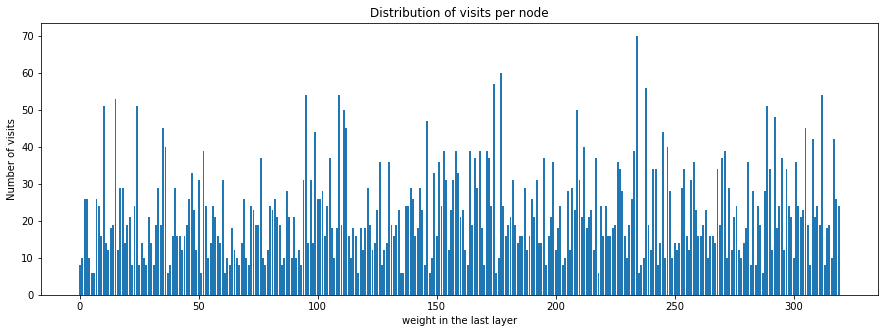

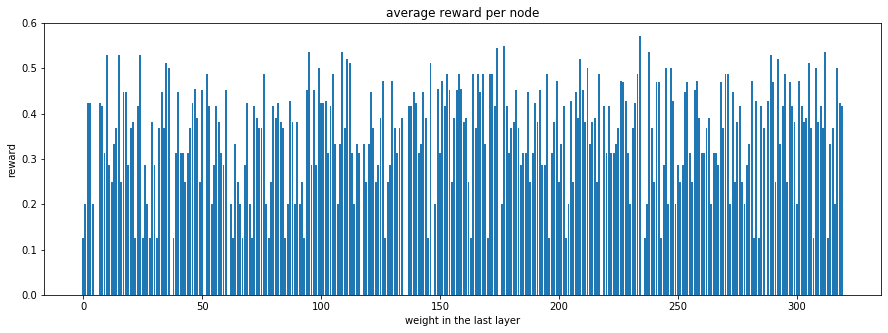

In [76]:
n2 = n_k.reshape(-1)
m2 = beta.reshape(-1)
plt.figure(figsize=(15,5))
plt.title("Distribution of visits per node")
plt.ylabel("Number of visits")
plt.xlabel("weight in the last layer")
plt.bar(np.arange(len(n2)), n2, )
plt.figure(figsize=(15,5))
plt.bar(np.arange(len(m2)),m2)
plt.title("average reward per node")
plt.ylabel("reward")
plt.xlabel("weight in the last layer")

In [72]:
indexes = np.unravel_index(np.argsort(beta, axis=None), beta.shape)
mu_k[indexes[0][-2:], indexes[1][-2:]]


array([0.13755775, 0.3652301 ])

In [55]:
data, label = data_prep("/home/fe/khodabakhshandeh/Projects/radar/radar-ml/Python/data/Config G/box_data.npy")

(59003, 1, 30, 30)
(59003,)


In [73]:
loss = []
accuracy = []
for i in range(0, 130):
    model = tf.keras.models.load_model("base_model_2")
    model.evaluate(data, label, verbose=0)
    W = model.layers[-1].get_weights()
    W_ = np.copy(W)
    W_[0][indexes[0][-(i+1):], indexes[1][-(i+1):]] = 0
    model.layers[-1].set_weights(W_)
    l, acc = model.evaluate(data, label)
    loss.append(l)
    accuracy.append(acc)



59003/59003 [==============================] - 2s 34us/sample - loss: 0.1533 - accuracy: 0.9542


No handles with labels found to put in legend.
No handles with labels found to put in legend.


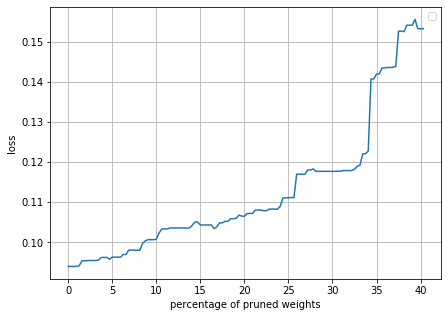

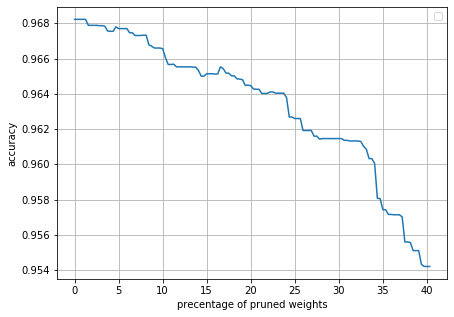

In [74]:
x = np.arange(len(accuracy))/mu_k.size *100
plt.figure(figsize=(7,5))
plt.plot(x, loss)
plt.ylabel("loss")
plt.xlabel("percentage of pruned weights")
plt.grid()
plt.legend()
plt.figure(figsize=(7,5))
plt.plot(x, accuracy)
plt.ylabel("accuracy")
plt.xlabel("precentage of pruned weights")
plt.grid()
plt.legend()

In [86]:
dataset = np.load("/home/fe/khodabakhshandeh/Projects/radar/radar-ml/Python/data/Config G/new_data.npy", allow_pickle=True)[()]

In [87]:
import pandas as pd
dataframe = pd.DataFrame.from_dict(dataset, orient="columns")

(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)


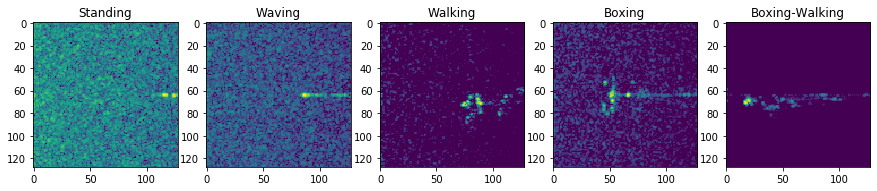

In [94]:
fig = plt.figure(figsize=(15,20))
t = ["Standing", "Waving", "Walking", "Boxing", "Boxing-Walking"]
for i in range(1,6):
    tmp = dataframe[dataframe["label"]==i].reset_index().loc[220]["data"]
    print(tmp.shape)
    ax = fig.add_subplot(1, 5, i)
    ax.imshow(tmp)
    plt.title(t[i-1])

In [73]:
dataframe[dataframe["label"]==2]["data"].loc[50]

KeyError: 50

In [51]:
dataframe["label"].unique()

array([1, 2, 3, 4, 5])